In [1]:
import numpy as np
import pandas as pd 
import os 

import itertools
import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from tqdm import tqdm

from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LogisticRegression

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import xgboost as xgb
from catboost import CatBoostRegressor
from mlxtend.regressor import StackingCVRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, MinMaxScaler

import shap

c:\Users\dmqa\anaconda3\envs\contest\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\dmqa\anaconda3\envs\contest\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# train / test data 

In [36]:
# train data 전처리 & 표준화(Standardization)

le = LabelEncoder()

train = pd.read_csv('D:\\workspace\\contest\\2022_weather\\data\\train\\train_ver1.csv')

le.fit(train.stnNm)
train['stnNm'] = le.transform(train.stnNm)

for col in train.columns:
    if train[col].dtype == 'object':
        train[col] = train[col].apply(lambda x : x.replace(',',''))
        train[col] = train[col].astype(int)

train_X = train.drop(['freq','tm'],axis = 1)
train_y = train['freq']

stan_scaler = StandardScaler()
stan_scaler.fit(train_X[train_X.columns.difference(['stnNm','sex'])])

train_X[train_X.columns.difference(['stnNm','sex'])] = stan_scaler.transform(train_X[train_X.columns.difference(['stnNm','sex'])])

X_train = train_X 
y_train = train_y

# X_train, X_valid, y_train, y_valid = train_test_split(train_X,train_y,test_size=0.2, shuffle = True, random_state= 13)

In [37]:
# validation data 전처리 

val = pd.read_csv('D:\\workspace\\contest\\2022_weather\\data\\final_val\\test_ver1.csv')

val.sort_values(by = ['yyyymmdd','sex'], axis=0,inplace=True)
val.reset_index(drop=True,inplace=True)

val['area'] = le.transform(val.area)
val['yyyymmdd'] = val.yyyymmdd.apply(lambda x : x.replace('-','')).astype(np.int64)


# columns 순서 변경
val_cols = ['area', 'yyyymmdd', 'sex', 'frequency', 'avgTa', 'minTa', 'maxTa',
       'sumRn', 'maxWs', 'avgWs', 'avgTd', 'minRhm', 'avgRhm', 'avgPv',
       'avgPa', 'avgPs', 'avgTs', 'minTg', '체감온도', '총_인구수', '10세이하_인구수',
       '10대_인구수', '20대_인구수', '30대_인구수', '40대_인구수', '50대_인구수', '60대_인구수',
       '70대_인구수', '80대_인구수', '90대_인구수', '100세이상_인구수', 'SPI1', 'SPI2', 'SPI3',
       'SPI4', 'SPI5', 'SPI6', 'SPI9', 'SPI12', 'SPI18', 'SPI24', '미세먼지농도','예보_3시간기온', '예보_강수확률', 
       '예보_습도', '예보_일최고기온', '예보_일최저기온', '예보_풍속', '예보_풍향']

# columns 명 변경
val = val.loc[:,val_cols]
val.columns = train.columns

# 인구 column , -> '' 으로 변경
for col in val.columns:
    if val[col].dtype == 'object':
        val[col] = val[col].apply(lambda x : x.replace(',',''))
        val[col] = val[col].astype(int)

X_test = val.drop(['freq','tm'],axis = 1)

stan_scaler = StandardScaler()
stan_scaler.fit(X_test[X_test.columns.difference(['stnNm','sex'])])

X_test[X_test.columns.difference(['stnNm','sex'])] = stan_scaler.transform(X_test[X_test.columns.difference(['stnNm','sex'])])

In [38]:
vif_out = ['10대_인구수', '총_인구수', '예보_3시간기온', '40대_인구수', 'avgTa', '20대_인구수', '60대_인구수', 
     '체감온도', '90대_인구수', 'avgTd', '예보_일최저기온', '30대_인구수', '70대_인구수', 'minTa', 
     'avgTs', '50대_인구수', 'minTg', '80대_인구수', 'maxTa', 'avgPv']

In [39]:
X_train = X_train.loc[:,~X_train.columns.isin(vif_out)]
X_test = X_test.loc[:,~X_test.columns.isin(vif_out)]

# RandomForest

In [5]:
def objective(trial):
    rf_estimators = trial.suggest_int('n_estimators', 100, 300)
    rf_depth = trial.suggest_int('max_depth', 3,8)
    rf_samples_leaf =  trial.suggest_int('min_samples_leaf',3,15)
    rf_samples_split =  trial.suggest_int('min_samples_split',2,10)
    rf_features =  trial.suggest_categorical('max_features', ['sqrt','log2'])

    regressor_obj = RandomForestRegressor(n_estimators=rf_estimators,max_depth=rf_depth,
                                        max_features=rf_features,
                                        min_samples_leaf=rf_samples_leaf,
                                        min_samples_split=rf_samples_split)

    rmse = np.sqrt(-cross_val_score(regressor_obj, X_train, y_train, scoring="neg_mean_squared_error", cv = 10, n_jobs=8))
    print(rmse)
    rmse = rmse.min()   
    return rmse

sampler = TPESampler(seed=42) # TPESampler --> MAE가 최소가 되는 방향으로 학습 진행 (MAE: 평균절대오차!)

study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(objective, n_trials=150)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

rf_best = study.best_params
# lgb_best = study_lgb.best_params
# xgb_best = study_xgb.best_params

model_rf = RandomForestRegressor(**rf_best)
model_rf.fit(X_train,y_train)

pred_rf = model_rf.predict(X_test)

df = pd.read_csv('./220153.csv',encoding='cp949')
df['frequency'] = pred_rf

df.to_csv('./220153_rf.csv',encoding='cp949',index=False)

[I 2022-07-26 10:28:54,961] A new study created in memory with name: no-name-00c4ccbf-736e-4b3f-a3cb-1e938f1b208c
[I 2022-07-26 10:29:25,319] Trial 0 finished with value: 1.2167138948606235 and parameters: {'n_estimators': 175, 'max_depth': 8, 'min_samples_leaf': 12, 'min_samples_split': 7, 'max_features': 'sqrt'}. Best is trial 0 with value: 1.2167138948606235.


[1.26744132 1.21671389 1.22638169 1.27684177 1.2351221  1.24876084
 1.24256017 1.26765342 1.29300799 1.27200949]


[I 2022-07-26 10:29:40,167] Trial 1 finished with value: 1.2164802913843586 and parameters: {'n_estimators': 111, 'max_depth': 8, 'min_samples_leaf': 10, 'min_samples_split': 8, 'max_features': 'log2'}. Best is trial 1 with value: 1.2164802913843586.


[1.26798949 1.21648029 1.22844162 1.27659598 1.2353579  1.24881991
 1.24234912 1.26789829 1.29479826 1.27487283]


[I 2022-07-26 10:29:59,528] Trial 2 finished with value: 1.2243709944195347 and parameters: {'n_estimators': 267, 'max_depth': 4, 'min_samples_leaf': 5, 'min_samples_split': 3, 'max_features': 'log2'}. Best is trial 1 with value: 1.2164802913843586.


[1.2745402  1.22437099 1.23593416 1.28548599 1.24366104 1.25587949
 1.2511791  1.28146486 1.30204696 1.28201646]


[I 2022-07-26 10:30:12,988] Trial 3 finished with value: 1.2232684735464014 and parameters: {'n_estimators': 186, 'max_depth': 4, 'min_samples_leaf': 10, 'min_samples_split': 3, 'max_features': 'log2'}. Best is trial 1 with value: 1.2164802913843586.


[1.27531959 1.22326847 1.23633728 1.28699079 1.24304879 1.25764682
 1.25137907 1.28072461 1.30150673 1.28191514]


[I 2022-07-26 10:30:40,611] Trial 4 finished with value: 1.2168265735059685 and parameters: {'n_estimators': 191, 'max_depth': 7, 'min_samples_leaf': 5, 'min_samples_split': 6, 'max_features': 'sqrt'}. Best is trial 1 with value: 1.2164802913843586.


[1.26761782 1.21682657 1.22767282 1.27600487 1.23572537 1.24814402
 1.24182377 1.26846523 1.29424981 1.27274873]


[I 2022-07-26 10:30:59,301] Trial 5 finished with value: 1.2220564667890623 and parameters: {'n_estimators': 222, 'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 10, 'max_features': 'sqrt'}. Best is trial 1 with value: 1.2164802913843586.


[1.27277401 1.22205647 1.23301709 1.28317436 1.24127578 1.25382473
 1.24865735 1.27886626 1.30024966 1.27925724]


[I 2022-07-26 10:31:08,176] Trial 6 finished with value: 1.2347813270209513 and parameters: {'n_estimators': 161, 'max_depth': 3, 'min_samples_leaf': 11, 'min_samples_split': 5, 'max_features': 'log2'}. Best is trial 1 with value: 1.2164802913843586.


[1.28707849 1.23478133 1.24869718 1.29755232 1.25523776 1.26729446
 1.26306013 1.30003696 1.31075334 1.29104284]


[I 2022-07-26 10:31:23,397] Trial 7 finished with value: 1.2190534250307834 and parameters: {'n_estimators': 106, 'max_depth': 8, 'min_samples_leaf': 6, 'min_samples_split': 7, 'max_features': 'log2'}. Best is trial 1 with value: 1.2164802913843586.


[1.26780829 1.21905343 1.22960217 1.27647772 1.23549419 1.24880205
 1.24113681 1.26781841 1.29376758 1.27280068]


[I 2022-07-26 10:31:41,670] Trial 8 finished with value: 1.2233222696139396 and parameters: {'n_estimators': 209, 'max_depth': 4, 'min_samples_leaf': 15, 'min_samples_split': 8, 'max_features': 'sqrt'}. Best is trial 1 with value: 1.2164802913843586.


[1.27397436 1.22332227 1.23397667 1.28311955 1.24170613 1.25413238
 1.24900765 1.27994077 1.29982975 1.27981464]


[I 2022-07-26 10:32:12,319] Trial 9 finished with value: 1.2185219244755623 and parameters: {'n_estimators': 220, 'max_depth': 8, 'min_samples_leaf': 4, 'min_samples_split': 3, 'max_features': 'log2'}. Best is trial 1 with value: 1.2164802913843586.


[1.26878853 1.21852192 1.22902133 1.27569227 1.23572677 1.24901712
 1.24236069 1.26799837 1.29373684 1.2720532 ]


[I 2022-07-26 10:32:23,082] Trial 10 finished with value: 1.2183955577430703 and parameters: {'n_estimators': 104, 'max_depth': 6, 'min_samples_leaf': 8, 'min_samples_split': 10, 'max_features': 'log2'}. Best is trial 1 with value: 1.2164802913843586.


[1.26841818 1.21839556 1.22874488 1.27762843 1.2374868  1.24989708
 1.24375566 1.27095213 1.29504675 1.27554273]


[I 2022-07-26 10:32:44,896] Trial 11 finished with value: 1.2178493775782528 and parameters: {'n_estimators': 147, 'max_depth': 7, 'min_samples_leaf': 13, 'min_samples_split': 8, 'max_features': 'sqrt'}. Best is trial 1 with value: 1.2164802913843586.


[1.26707948 1.21784938 1.22662809 1.27634807 1.23604556 1.24886477
 1.24178806 1.26956229 1.29273366 1.27247421]


[I 2022-07-26 10:33:05,811] Trial 12 finished with value: 1.2173085067685907 and parameters: {'n_estimators': 144, 'max_depth': 7, 'min_samples_leaf': 12, 'min_samples_split': 8, 'max_features': 'sqrt'}. Best is trial 1 with value: 1.2164802913843586.


[1.26800466 1.21730851 1.22694848 1.276217   1.23583783 1.24902316
 1.24183229 1.26866597 1.29325657 1.27255974]


[I 2022-07-26 10:33:47,660] Trial 13 finished with value: 1.2170316875544578 and parameters: {'n_estimators': 258, 'max_depth': 8, 'min_samples_leaf': 9, 'min_samples_split': 5, 'max_features': 'sqrt'}. Best is trial 1 with value: 1.2164802913843586.


[1.26721992 1.21703169 1.22775842 1.27576677 1.2345396  1.24856255
 1.24145049 1.26807773 1.29359645 1.27126068]


[I 2022-07-26 10:34:00,538] Trial 14 finished with value: 1.2189591134873272 and parameters: {'n_estimators': 129, 'max_depth': 6, 'min_samples_leaf': 14, 'min_samples_split': 9, 'max_features': 'log2'}. Best is trial 1 with value: 1.2164802913843586.


[1.26819947 1.21895911 1.22742558 1.27853831 1.2371379  1.25046908
 1.24390055 1.27109122 1.29459618 1.27433675]


[I 2022-07-26 10:34:42,924] Trial 15 finished with value: 1.215921228055471 and parameters: {'n_estimators': 294, 'max_depth': 7, 'min_samples_leaf': 8, 'min_samples_split': 6, 'max_features': 'sqrt'}. Best is trial 15 with value: 1.215921228055471.


[1.26773361 1.21592123 1.22775515 1.27632699 1.23518545 1.24874749
 1.24162943 1.2683147  1.29372227 1.27304223]


[I 2022-07-26 10:35:20,904] Trial 16 finished with value: 1.2175326654024947 and parameters: {'n_estimators': 300, 'max_depth': 6, 'min_samples_leaf': 7, 'min_samples_split': 5, 'max_features': 'sqrt'}. Best is trial 15 with value: 1.215921228055471.


[1.26764964 1.21753267 1.22786541 1.27662419 1.23600546 1.24966635
 1.24224002 1.27054651 1.29489832 1.27370838]


[I 2022-07-26 10:35:59,886] Trial 17 finished with value: 1.216877589220765 and parameters: {'n_estimators': 300, 'max_depth': 7, 'min_samples_leaf': 9, 'min_samples_split': 6, 'max_features': 'log2'}. Best is trial 15 with value: 1.215921228055471.


[1.26804382 1.21687759 1.22742388 1.27679523 1.23555257 1.24885106
 1.24248535 1.26886447 1.29394927 1.27295413]


[I 2022-07-26 10:36:22,014] Trial 18 finished with value: 1.2195542365961924 and parameters: {'n_estimators': 250, 'max_depth': 5, 'min_samples_leaf': 7, 'min_samples_split': 4, 'max_features': 'log2'}. Best is trial 15 with value: 1.215921228055471.


[1.26934071 1.21955424 1.23057594 1.28032673 1.23888795 1.25170396
 1.24596454 1.27480508 1.29686481 1.27721798]


[I 2022-07-26 10:36:55,843] Trial 19 finished with value: 1.2163732057053822 and parameters: {'n_estimators': 233, 'max_depth': 7, 'min_samples_leaf': 10, 'min_samples_split': 7, 'max_features': 'sqrt'}. Best is trial 15 with value: 1.215921228055471.


[1.26756155 1.21637321 1.22721431 1.27610095 1.2349642  1.2487936
 1.24239898 1.26859161 1.29351211 1.27193419]


[I 2022-07-26 10:37:25,458] Trial 20 finished with value: 1.2185409842156405 and parameters: {'n_estimators': 278, 'max_depth': 5, 'min_samples_leaf': 7, 'min_samples_split': 6, 'max_features': 'sqrt'}. Best is trial 15 with value: 1.215921228055471.


[1.2700329  1.21854098 1.23012874 1.27966636 1.23751303 1.25066953
 1.24443101 1.27276547 1.29620462 1.27580047]


[I 2022-07-26 10:38:00,132] Trial 21 finished with value: 1.2161699203845389 and parameters: {'n_estimators': 239, 'max_depth': 7, 'min_samples_leaf': 10, 'min_samples_split': 7, 'max_features': 'sqrt'}. Best is trial 15 with value: 1.215921228055471.


[1.26864416 1.21616992 1.22710598 1.27588879 1.23514543 1.24912588
 1.24151403 1.26864899 1.29400498 1.27269887]


[I 2022-07-26 10:38:34,396] Trial 22 finished with value: 1.2165563411170266 and parameters: {'n_estimators': 241, 'max_depth': 7, 'min_samples_leaf': 10, 'min_samples_split': 7, 'max_features': 'sqrt'}. Best is trial 15 with value: 1.215921228055471.


[1.26773937 1.21655634 1.22716267 1.27610004 1.23608695 1.24899453
 1.24156127 1.26805716 1.29342496 1.27236934]


[I 2022-07-26 10:39:03,181] Trial 23 finished with value: 1.2168585039633977 and parameters: {'n_estimators': 234, 'max_depth': 6, 'min_samples_leaf': 8, 'min_samples_split': 7, 'max_features': 'sqrt'}. Best is trial 15 with value: 1.215921228055471.


[1.26829547 1.2168585  1.22801875 1.27659063 1.23522851 1.24964228
 1.24271456 1.26992797 1.29426062 1.27424064]


[I 2022-07-26 10:39:42,496] Trial 24 finished with value: 1.2159640082691892 and parameters: {'n_estimators': 276, 'max_depth': 7, 'min_samples_leaf': 11, 'min_samples_split': 9, 'max_features': 'sqrt'}. Best is trial 15 with value: 1.215921228055471.


[1.26744584 1.21596401 1.22801332 1.27603725 1.23544787 1.24882537
 1.24227835 1.26872422 1.29438111 1.27249247]


[I 2022-07-26 10:40:16,778] Trial 25 finished with value: 1.2168735598538423 and parameters: {'n_estimators': 281, 'max_depth': 6, 'min_samples_leaf': 12, 'min_samples_split': 9, 'max_features': 'sqrt'}. Best is trial 15 with value: 1.215921228055471.


[1.26828495 1.21687356 1.22659706 1.27687735 1.23536706 1.24968414
 1.24262694 1.27015973 1.29445397 1.27373816]


[I 2022-07-26 10:40:56,514] Trial 26 finished with value: 1.216169654148914 and parameters: {'n_estimators': 281, 'max_depth': 7, 'min_samples_leaf': 11, 'min_samples_split': 9, 'max_features': 'sqrt'}. Best is trial 15 with value: 1.215921228055471.


[1.26845603 1.21616965 1.22644537 1.27602855 1.23521704 1.24862167
 1.24162153 1.26809499 1.29321203 1.27262942]


[I 2022-07-26 10:41:25,425] Trial 27 finished with value: 1.218988227817717 and parameters: {'n_estimators': 281, 'max_depth': 5, 'min_samples_leaf': 13, 'min_samples_split': 9, 'max_features': 'sqrt'}. Best is trial 15 with value: 1.215921228055471.


[1.26838761 1.21898823 1.22965907 1.27899361 1.23736487 1.25120513
 1.24445788 1.27375167 1.29643984 1.27623286]


[I 2022-07-26 10:42:02,922] Trial 28 finished with value: 1.216470638402345 and parameters: {'n_estimators': 265, 'max_depth': 7, 'min_samples_leaf': 11, 'min_samples_split': 10, 'max_features': 'sqrt'}. Best is trial 15 with value: 1.215921228055471.


[1.26928527 1.21647064 1.22698515 1.27585293 1.23539799 1.2490868
 1.24238474 1.26840621 1.29357702 1.27296403]


[I 2022-07-26 10:42:48,854] Trial 29 finished with value: 1.2156281428314608 and parameters: {'n_estimators': 288, 'max_depth': 8, 'min_samples_leaf': 11, 'min_samples_split': 9, 'max_features': 'sqrt'}. Best is trial 29 with value: 1.2156281428314608.


[1.26818958 1.21562814 1.22724981 1.27532838 1.23536187 1.24874509
 1.24131447 1.26739474 1.29298755 1.27189038]


[I 2022-07-26 10:43:35,197] Trial 30 finished with value: 1.2161383924157927 and parameters: {'n_estimators': 291, 'max_depth': 8, 'min_samples_leaf': 13, 'min_samples_split': 2, 'max_features': 'sqrt'}. Best is trial 29 with value: 1.2156281428314608.


[1.26760961 1.21613839 1.22564305 1.27640924 1.23478709 1.24897801
 1.24213433 1.26781148 1.2932799  1.27337257]


[I 2022-07-26 10:44:21,375] Trial 31 finished with value: 1.2160062925125612 and parameters: {'n_estimators': 291, 'max_depth': 8, 'min_samples_leaf': 13, 'min_samples_split': 2, 'max_features': 'sqrt'}. Best is trial 29 with value: 1.2156281428314608.


[1.26772809 1.21600629 1.22687114 1.27592819 1.2349019  1.24846936
 1.24140283 1.2680784  1.29230184 1.27265311]


[I 2022-07-26 10:45:04,047] Trial 32 finished with value: 1.2165671883008053 and parameters: {'n_estimators': 267, 'max_depth': 8, 'min_samples_leaf': 12, 'min_samples_split': 2, 'max_features': 'sqrt'}. Best is trial 29 with value: 1.2156281428314608.


[1.26853909 1.21656719 1.22647122 1.27591279 1.23496245 1.24861893
 1.2416738  1.26752812 1.29366295 1.27200191]


[I 2022-07-26 10:45:51,424] Trial 33 finished with value: 1.2166797922194408 and parameters: {'n_estimators': 291, 'max_depth': 8, 'min_samples_leaf': 14, 'min_samples_split': 4, 'max_features': 'sqrt'}. Best is trial 29 with value: 1.2156281428314608.


[1.26776769 1.21667979 1.22625243 1.27628414 1.23473474 1.24836704
 1.24167974 1.26814979 1.29312125 1.27209928]


[I 2022-07-26 10:46:31,810] Trial 34 finished with value: 1.2160944042639816 and parameters: {'n_estimators': 253, 'max_depth': 8, 'min_samples_leaf': 15, 'min_samples_split': 4, 'max_features': 'sqrt'}. Best is trial 29 with value: 1.2156281428314608.


[1.26817344 1.2160944  1.22671753 1.27567075 1.23485783 1.2481187
 1.24130562 1.26821071 1.29321764 1.27265626]


[I 2022-07-26 10:47:14,659] Trial 35 finished with value: 1.216190351392038 and parameters: {'n_estimators': 268, 'max_depth': 8, 'min_samples_leaf': 11, 'min_samples_split': 9, 'max_features': 'sqrt'}. Best is trial 29 with value: 1.2156281428314608.


[1.2679825  1.21619035 1.22709883 1.27583417 1.23536963 1.24892363
 1.24124175 1.26795663 1.29370096 1.27269675]


[I 2022-07-26 10:48:01,209] Trial 36 finished with value: 1.2166599286562274 and parameters: {'n_estimators': 291, 'max_depth': 8, 'min_samples_leaf': 8, 'min_samples_split': 8, 'max_features': 'sqrt'}. Best is trial 29 with value: 1.2156281428314608.


[1.26769516 1.21665993 1.22800967 1.27611174 1.23559426 1.24868984
 1.24144222 1.26664995 1.294157   1.27302234]


[I 2022-07-26 10:48:40,120] Trial 37 finished with value: 1.2163960581436493 and parameters: {'n_estimators': 274, 'max_depth': 7, 'min_samples_leaf': 12, 'min_samples_split': 3, 'max_features': 'sqrt'}. Best is trial 29 with value: 1.2156281428314608.


[1.26698813 1.21639606 1.22644941 1.27686309 1.23558932 1.24895518
 1.24162333 1.26803446 1.29328815 1.27293211]


[I 2022-07-26 10:49:28,365] Trial 38 finished with value: 1.2178905158134528 and parameters: {'n_estimators': 300, 'max_depth': 8, 'min_samples_leaf': 9, 'min_samples_split': 10, 'max_features': 'sqrt'}. Best is trial 29 with value: 1.2156281428314608.


[1.26779216 1.21789052 1.22749266 1.27586585 1.23493047 1.24865137
 1.24240147 1.26822402 1.29312931 1.27189081]


[I 2022-07-26 10:49:57,119] Trial 39 finished with value: 1.2171911975267624 and parameters: {'n_estimators': 182, 'max_depth': 8, 'min_samples_leaf': 14, 'min_samples_split': 6, 'max_features': 'sqrt'}. Best is trial 29 with value: 1.2156281428314608.


[1.26646995 1.2171912  1.22641103 1.27592864 1.23572231 1.24818601
 1.24140181 1.2676538  1.29387097 1.27321862]


[I 2022-07-26 10:50:10,549] Trial 40 finished with value: 1.230719359594572 and parameters: {'n_estimators': 206, 'max_depth': 3, 'min_samples_leaf': 11, 'min_samples_split': 2, 'max_features': 'sqrt'}. Best is trial 29 with value: 1.2156281428314608.


[1.28274527 1.23071936 1.24392911 1.29259561 1.24982871 1.2616934
 1.26073667 1.29071481 1.30829756 1.28819717]


[I 2022-07-26 10:50:50,718] Trial 41 finished with value: 1.2163955234517785 and parameters: {'n_estimators': 250, 'max_depth': 8, 'min_samples_leaf': 15, 'min_samples_split': 4, 'max_features': 'sqrt'}. Best is trial 29 with value: 1.2156281428314608.


[1.26723264 1.21639552 1.22651554 1.27629234 1.23477117 1.24861886
 1.24148856 1.26747365 1.29331005 1.27251368]


[I 2022-07-26 10:51:32,067] Trial 42 finished with value: 1.2156963757845494 and parameters: {'n_estimators': 260, 'max_depth': 8, 'min_samples_leaf': 15, 'min_samples_split': 3, 'max_features': 'sqrt'}. Best is trial 29 with value: 1.2156281428314608.


[1.26797917 1.21569638 1.22652118 1.27620805 1.2351014  1.24916113
 1.24171858 1.2677285  1.29401278 1.27162915]


[I 2022-07-26 10:52:13,032] Trial 43 finished with value: 1.2165290991482491 and parameters: {'n_estimators': 289, 'max_depth': 7, 'min_samples_leaf': 13, 'min_samples_split': 3, 'max_features': 'sqrt'}. Best is trial 29 with value: 1.2156281428314608.


[1.26656578 1.2165291  1.22548857 1.27612311 1.23502886 1.24935964
 1.241659   1.26834817 1.29351755 1.27251677]


[I 2022-07-26 10:52:54,483] Trial 44 finished with value: 1.2167482054528347 and parameters: {'n_estimators': 260, 'max_depth': 8, 'min_samples_leaf': 14, 'min_samples_split': 2, 'max_features': 'sqrt'}. Best is trial 29 with value: 1.2156281428314608.


[1.26830898 1.21674821 1.225637   1.27584791 1.23466832 1.24831376
 1.24097989 1.26724105 1.29333919 1.27307608]


[I 2022-07-26 10:53:32,904] Trial 45 finished with value: 1.2164547745884546 and parameters: {'n_estimators': 273, 'max_depth': 7, 'min_samples_leaf': 15, 'min_samples_split': 3, 'max_features': 'sqrt'}. Best is trial 29 with value: 1.2156281428314608.


[1.26791466 1.21645477 1.22555581 1.27603574 1.23498188 1.24917565
 1.24193327 1.26914523 1.29337911 1.27304676]


[I 2022-07-26 10:54:18,712] Trial 46 finished with value: 1.2178005692161298 and parameters: {'n_estimators': 287, 'max_depth': 8, 'min_samples_leaf': 6, 'min_samples_split': 2, 'max_features': 'sqrt'}. Best is trial 29 with value: 1.2156281428314608.


[1.26819188 1.21780057 1.22756478 1.27603927 1.23607814 1.248927
 1.24174706 1.26670734 1.29319889 1.2733054 ]


[I 2022-07-26 10:54:47,832] Trial 47 finished with value: 1.2161297188959515 and parameters: {'n_estimators': 218, 'max_depth': 8, 'min_samples_leaf': 13, 'min_samples_split': 8, 'max_features': 'log2'}. Best is trial 29 with value: 1.2156281428314608.


[1.26774078 1.21612972 1.22650937 1.27638698 1.23544223 1.24892182
 1.24220449 1.26788989 1.29398394 1.27279739]


[I 2022-07-26 10:55:20,605] Trial 48 finished with value: 1.2173206039270996 and parameters: {'n_estimators': 259, 'max_depth': 6, 'min_samples_leaf': 14, 'min_samples_split': 3, 'max_features': 'sqrt'}. Best is trial 29 with value: 1.2156281428314608.


[1.2683357  1.2173206  1.22728538 1.27747874 1.2360396  1.24960432
 1.24283607 1.27013543 1.29447049 1.27383885]


[I 2022-07-26 10:56:03,221] Trial 49 finished with value: 1.2176800047163756 and parameters: {'n_estimators': 284, 'max_depth': 7, 'min_samples_leaf': 9, 'min_samples_split': 8, 'max_features': 'sqrt'}. Best is trial 29 with value: 1.2156281428314608.


[1.26713529 1.21768    1.22688277 1.27576441 1.23571577 1.24842131
 1.24150566 1.26798246 1.29335676 1.27266421]


[I 2022-07-26 10:56:36,244] Trial 50 finished with value: 1.2171111481981918 and parameters: {'n_estimators': 273, 'max_depth': 7, 'min_samples_leaf': 12, 'min_samples_split': 5, 'max_features': 'log2'}. Best is trial 29 with value: 1.2156281428314608.


[1.26668586 1.21711115 1.22561864 1.27651709 1.23537305 1.24942318
 1.24269981 1.26895308 1.29367078 1.27383546]


[I 2022-07-26 10:57:16,324] Trial 51 finished with value: 1.2160611479193135 and parameters: {'n_estimators': 252, 'max_depth': 8, 'min_samples_leaf': 15, 'min_samples_split': 4, 'max_features': 'sqrt'}. Best is trial 29 with value: 1.2156281428314608.


[1.267034   1.21606115 1.22712284 1.27581337 1.23522654 1.248787
 1.24187627 1.26671035 1.29389337 1.2731367 ]


[I 2022-07-26 10:58:02,953] Trial 52 finished with value: 1.2160454946157384 and parameters: {'n_estimators': 293, 'max_depth': 8, 'min_samples_leaf': 15, 'min_samples_split': 4, 'max_features': 'sqrt'}. Best is trial 29 with value: 1.2156281428314608.


[1.26689874 1.21604549 1.22656006 1.27602733 1.23495717 1.24933626
 1.24145271 1.26746695 1.29298296 1.27320586]


[I 2022-07-26 10:58:49,726] Trial 53 finished with value: 1.2171969938652172 and parameters: {'n_estimators': 295, 'max_depth': 8, 'min_samples_leaf': 14, 'min_samples_split': 3, 'max_features': 'sqrt'}. Best is trial 29 with value: 1.2156281428314608.


[1.26713596 1.21719699 1.22648992 1.27627042 1.23541429 1.24852155
 1.24150219 1.26781341 1.29325745 1.27147754]


[I 2022-07-26 10:59:15,788] Trial 54 finished with value: 1.2171583508577446 and parameters: {'n_estimators': 165, 'max_depth': 8, 'min_samples_leaf': 8, 'min_samples_split': 5, 'max_features': 'sqrt'}. Best is trial 29 with value: 1.2156281428314608.


[1.26711719 1.21715835 1.22828281 1.27581658 1.23510525 1.24941887
 1.24198107 1.26705734 1.29289867 1.27307296]


[I 2022-07-26 11:00:03,494] Trial 55 finished with value: 1.2178621904270426 and parameters: {'n_estimators': 296, 'max_depth': 8, 'min_samples_leaf': 3, 'min_samples_split': 3, 'max_features': 'sqrt'}. Best is trial 29 with value: 1.2156281428314608.


[1.26915665 1.21786219 1.23063955 1.27621233 1.23597919 1.24846833
 1.2416102  1.2681249  1.29439005 1.27402063]


[I 2022-07-26 11:00:42,484] Trial 56 finished with value: 1.2173379281585306 and parameters: {'n_estimators': 276, 'max_depth': 7, 'min_samples_leaf': 15, 'min_samples_split': 5, 'max_features': 'sqrt'}. Best is trial 29 with value: 1.2156281428314608.


[1.26828148 1.21733793 1.22649578 1.27631472 1.23555465 1.24939819
 1.24121664 1.26871334 1.29336653 1.27318882]


[I 2022-07-26 11:01:20,699] Trial 57 finished with value: 1.2169381475849932 and parameters: {'n_estimators': 284, 'max_depth': 8, 'min_samples_leaf': 10, 'min_samples_split': 2, 'max_features': 'log2'}. Best is trial 29 with value: 1.2156281428314608.


[1.26812139 1.21693815 1.22710434 1.27622112 1.23502047 1.24885578
 1.2420326  1.26779159 1.29347539 1.27209105]


[I 2022-07-26 11:01:53,548] Trial 58 finished with value: 1.2161162247282467 and parameters: {'n_estimators': 266, 'max_depth': 6, 'min_samples_leaf': 13, 'min_samples_split': 4, 'max_features': 'sqrt'}. Best is trial 29 with value: 1.2156281428314608.


[1.26723044 1.21611622 1.22762309 1.27732448 1.23603131 1.24956757
 1.24284555 1.27027546 1.29402753 1.27385346]


[I 2022-07-26 11:02:36,418] Trial 59 finished with value: 1.2174915097003143 and parameters: {'n_estimators': 300, 'max_depth': 7, 'min_samples_leaf': 6, 'min_samples_split': 9, 'max_features': 'sqrt'}. Best is trial 29 with value: 1.2156281428314608.


[1.26842356 1.21749151 1.22808538 1.27627315 1.23552964 1.24943048
 1.24190154 1.26830262 1.29425945 1.27234032]


[I 2022-07-26 11:03:00,532] Trial 60 finished with value: 1.2225700566137256 and parameters: {'n_estimators': 286, 'max_depth': 4, 'min_samples_leaf': 14, 'min_samples_split': 10, 'max_features': 'sqrt'}. Best is trial 29 with value: 1.2156281428314608.


[1.27204145 1.22257006 1.23369464 1.28379713 1.24021304 1.25364325
 1.2485589  1.2796192  1.2994913  1.27920181]


[I 2022-07-26 11:03:41,781] Trial 61 finished with value: 1.2163212230556708 and parameters: {'n_estimators': 242, 'max_depth': 8, 'min_samples_leaf': 15, 'min_samples_split': 6, 'max_features': 'sqrt'}. Best is trial 29 with value: 1.2156281428314608.


[1.26688973 1.21632122 1.22677237 1.27531765 1.23435924 1.24936291
 1.24155888 1.26821272 1.29298247 1.27340517]


[I 2022-07-26 11:04:25,157] Trial 62 finished with value: 1.2170168017569165 and parameters: {'n_estimators': 273, 'max_depth': 8, 'min_samples_leaf': 15, 'min_samples_split': 4, 'max_features': 'sqrt'}. Best is trial 29 with value: 1.2156281428314608.


[1.26790883 1.2170168  1.22631923 1.27646809 1.23529786 1.2487076
 1.24172922 1.26758774 1.29373961 1.27303851]


[I 2022-07-26 11:04:43,472] Trial 63 finished with value: 1.2173214366119445 and parameters: {'n_estimators': 119, 'max_depth': 8, 'min_samples_leaf': 15, 'min_samples_split': 4, 'max_features': 'sqrt'}. Best is trial 29 with value: 1.2156281428314608.


[1.26630359 1.21732144 1.22807086 1.27626501 1.23564672 1.24883182
 1.24139476 1.26904554 1.2934212  1.27289996]


[I 2022-07-26 11:05:24,209] Trial 64 finished with value: 1.2158796855480642 and parameters: {'n_estimators': 253, 'max_depth': 8, 'min_samples_leaf': 13, 'min_samples_split': 5, 'max_features': 'sqrt'}. Best is trial 29 with value: 1.2156281428314608.


[1.26790404 1.21587969 1.22734474 1.27633566 1.23449037 1.2490055
 1.2415034  1.2684068  1.2934746  1.27304573]


[I 2022-07-26 11:06:01,354] Trial 65 finished with value: 1.216587631571705 and parameters: {'n_estimators': 259, 'max_depth': 7, 'min_samples_leaf': 12, 'min_samples_split': 6, 'max_features': 'sqrt'}. Best is trial 29 with value: 1.2156281428314608.


[1.26853172 1.21658763 1.22684184 1.27650906 1.23483035 1.2483235
 1.24182622 1.26883612 1.29325648 1.27235686]


[I 2022-07-26 11:06:46,114] Trial 66 finished with value: 1.2170452327273338 and parameters: {'n_estimators': 279, 'max_depth': 8, 'min_samples_leaf': 11, 'min_samples_split': 5, 'max_features': 'sqrt'}. Best is trial 29 with value: 1.2156281428314608.


[1.26833507 1.21704523 1.22713005 1.27639079 1.23565254 1.24807536
 1.24114493 1.2668284  1.29262526 1.27281023]


[I 2022-07-26 11:07:06,788] Trial 67 finished with value: 1.2183613093649417 and parameters: {'n_estimators': 195, 'max_depth': 5, 'min_samples_leaf': 9, 'min_samples_split': 6, 'max_features': 'sqrt'}. Best is trial 29 with value: 1.2156281428314608.


[1.2701211  1.21836131 1.22962668 1.2798473  1.23792366 1.25083584
 1.243904   1.27384556 1.29551451 1.27555406]


[I 2022-07-26 11:07:46,681] Trial 68 finished with value: 1.2164381303498817 and parameters: {'n_estimators': 293, 'max_depth': 8, 'min_samples_leaf': 10, 'min_samples_split': 5, 'max_features': 'log2'}. Best is trial 29 with value: 1.2156281428314608.


[1.26634825 1.21643813 1.22717391 1.27600658 1.23519763 1.24855276
 1.24166949 1.26812983 1.29346305 1.27286682]


[I 2022-07-26 11:08:21,338] Trial 69 finished with value: 1.216759637385479 and parameters: {'n_estimators': 244, 'max_depth': 7, 'min_samples_leaf': 13, 'min_samples_split': 7, 'max_features': 'sqrt'}. Best is trial 29 with value: 1.2156281428314608.


[1.26681939 1.21675964 1.22654528 1.27637886 1.23535402 1.24896732
 1.24189616 1.26801757 1.29345616 1.27362644]


[I 2022-07-26 11:08:57,182] Trial 70 finished with value: 1.2159656880895784 and parameters: {'n_estimators': 224, 'max_depth': 8, 'min_samples_leaf': 14, 'min_samples_split': 6, 'max_features': 'sqrt'}. Best is trial 29 with value: 1.2156281428314608.


[1.26716    1.21596569 1.22723064 1.27596419 1.23520021 1.2477349
 1.24195709 1.26814564 1.29276289 1.2729116 ]


[I 2022-07-26 11:09:32,865] Trial 71 finished with value: 1.2167235708400632 and parameters: {'n_estimators': 224, 'max_depth': 8, 'min_samples_leaf': 14, 'min_samples_split': 6, 'max_features': 'sqrt'}. Best is trial 29 with value: 1.2156281428314608.


[1.26839506 1.21672357 1.22620382 1.27688233 1.23404195 1.24938949
 1.2415206  1.26825164 1.29334161 1.27355853]


[I 2022-07-26 11:10:11,060] Trial 72 finished with value: 1.2166149892490938 and parameters: {'n_estimators': 236, 'max_depth': 8, 'min_samples_leaf': 14, 'min_samples_split': 7, 'max_features': 'sqrt'}. Best is trial 29 with value: 1.2156281428314608.


[1.26701606 1.21661499 1.22724698 1.27587158 1.23513252 1.24872574
 1.24209132 1.2676111  1.2936617  1.27281793]


[I 2022-07-26 11:10:54,500] Trial 73 finished with value: 1.216661300342015 and parameters: {'n_estimators': 269, 'max_depth': 8, 'min_samples_leaf': 12, 'min_samples_split': 5, 'max_features': 'sqrt'}. Best is trial 29 with value: 1.2156281428314608.


[1.26784838 1.2166613  1.2267049  1.27580264 1.23488358 1.24868586
 1.24152837 1.26716481 1.29311371 1.27347976]


[I 2022-07-26 11:11:39,090] Trial 74 finished with value: 1.2157593626844512 and parameters: {'n_estimators': 281, 'max_depth': 8, 'min_samples_leaf': 13, 'min_samples_split': 6, 'max_features': 'sqrt'}. Best is trial 29 with value: 1.2156281428314608.


[1.26764832 1.21575936 1.22662461 1.27606196 1.23537575 1.24807651
 1.2409413  1.26781673 1.29277031 1.272536  ]


[I 2022-07-26 11:12:15,803] Trial 75 finished with value: 1.216076476614755 and parameters: {'n_estimators': 261, 'max_depth': 7, 'min_samples_leaf': 13, 'min_samples_split': 6, 'max_features': 'sqrt'}. Best is trial 29 with value: 1.2156281428314608.


[1.2677211  1.21607648 1.22638392 1.27603331 1.23527462 1.24886667
 1.24141455 1.2679047  1.29359307 1.27271219]


[I 2022-07-26 11:13:00,214] Trial 76 finished with value: 1.217152247604097 and parameters: {'n_estimators': 280, 'max_depth': 8, 'min_samples_leaf': 13, 'min_samples_split': 7, 'max_features': 'sqrt'}. Best is trial 29 with value: 1.2156281428314608.


[1.26786701 1.21715225 1.2261853  1.27611948 1.23497064 1.24836884
 1.24076087 1.26774347 1.2933913  1.2726842 ]


[I 2022-07-26 11:13:38,984] Trial 77 finished with value: 1.2158282026939096 and parameters: {'n_estimators': 245, 'max_depth': 8, 'min_samples_leaf': 12, 'min_samples_split': 6, 'max_features': 'sqrt'}. Best is trial 29 with value: 1.2156281428314608.


[1.26756984 1.2158282  1.22708044 1.27550935 1.23480747 1.24875475
 1.24175158 1.26746607 1.29271511 1.27322131]


[I 2022-07-26 11:14:18,036] Trial 78 finished with value: 1.2169923897533699 and parameters: {'n_estimators': 247, 'max_depth': 8, 'min_samples_leaf': 12, 'min_samples_split': 6, 'max_features': 'sqrt'}. Best is trial 29 with value: 1.2156281428314608.


[1.2678098  1.21699239 1.22714574 1.276042   1.23462723 1.24993484
 1.24131117 1.26769628 1.29310409 1.27175725]


[I 2022-07-26 11:14:50,236] Trial 79 finished with value: 1.2174101817069047 and parameters: {'n_estimators': 230, 'max_depth': 7, 'min_samples_leaf': 11, 'min_samples_split': 7, 'max_features': 'sqrt'}. Best is trial 29 with value: 1.2156281428314608.


[1.26902284 1.21741018 1.226928   1.27580398 1.23508276 1.24911821
 1.24190746 1.26864665 1.29348913 1.27325976]


[I 2022-07-26 11:15:15,683] Trial 80 finished with value: 1.2172448399068254 and parameters: {'n_estimators': 210, 'max_depth': 6, 'min_samples_leaf': 7, 'min_samples_split': 6, 'max_features': 'sqrt'}. Best is trial 29 with value: 1.2156281428314608.


[1.26810394 1.21724484 1.22816231 1.27693969 1.23589059 1.24934366
 1.24256255 1.2704595  1.2944835  1.27434674]


[I 2022-07-26 11:15:52,131] Trial 81 finished with value: 1.2173146484247923 and parameters: {'n_estimators': 228, 'max_depth': 8, 'min_samples_leaf': 12, 'min_samples_split': 6, 'max_features': 'sqrt'}. Best is trial 29 with value: 1.2156281428314608.


[1.26772693 1.21731465 1.22693155 1.27625724 1.23488902 1.24869835
 1.24200277 1.26795596 1.29305617 1.27294366]


[I 2022-07-26 11:16:32,332] Trial 82 finished with value: 1.217191410399913 and parameters: {'n_estimators': 253, 'max_depth': 8, 'min_samples_leaf': 13, 'min_samples_split': 9, 'max_features': 'sqrt'}. Best is trial 29 with value: 1.2156281428314608.


[1.26874414 1.21719141 1.22716439 1.27627822 1.23508076 1.24856061
 1.24130847 1.26819307 1.29341188 1.27212954]


[I 2022-07-26 11:17:14,267] Trial 83 finished with value: 1.2165225626605 and parameters: {'n_estimators': 264, 'max_depth': 8, 'min_samples_leaf': 11, 'min_samples_split': 8, 'max_features': 'sqrt'}. Best is trial 29 with value: 1.2156281428314608.


[1.2690217  1.21652256 1.22703157 1.27632249 1.23523216 1.24864979
 1.2413571  1.2671047  1.29304607 1.27271934]


[I 2022-07-26 11:17:54,447] Trial 84 finished with value: 1.2166950329495865 and parameters: {'n_estimators': 255, 'max_depth': 8, 'min_samples_leaf': 12, 'min_samples_split': 6, 'max_features': 'sqrt'}. Best is trial 29 with value: 1.2156281428314608.


[1.26767711 1.21669503 1.2268537  1.27611691 1.23510345 1.24767974
 1.24106827 1.26749511 1.29273993 1.27254264]


[I 2022-07-26 11:18:37,153] Trial 85 finished with value: 1.2159560216882352 and parameters: {'n_estimators': 269, 'max_depth': 8, 'min_samples_leaf': 13, 'min_samples_split': 7, 'max_features': 'sqrt'}. Best is trial 29 with value: 1.2156281428314608.


[1.26793941 1.21595602 1.22723059 1.27607964 1.23551309 1.24879245
 1.24158591 1.26776564 1.29325897 1.27290833]


[I 2022-07-26 11:19:05,615] Trial 86 finished with value: 1.2161511527503948 and parameters: {'n_estimators': 216, 'max_depth': 8, 'min_samples_leaf': 13, 'min_samples_split': 7, 'max_features': 'log2'}. Best is trial 29 with value: 1.2156281428314608.


[1.26695656 1.21615115 1.2260926  1.2759331  1.23584208 1.24957487
 1.24126263 1.26809944 1.29311769 1.27220367]


[I 2022-07-26 11:19:48,807] Trial 87 finished with value: 1.2171015406209849 and parameters: {'n_estimators': 270, 'max_depth': 8, 'min_samples_leaf': 8, 'min_samples_split': 9, 'max_features': 'sqrt'}. Best is trial 29 with value: 1.2156281428314608.


[1.26763098 1.21710154 1.2278402  1.27600204 1.23489069 1.24919529
 1.24272868 1.26833006 1.2933324  1.27175638]


[I 2022-07-26 11:20:25,444] Trial 88 finished with value: 1.2169677679184945 and parameters: {'n_estimators': 262, 'max_depth': 7, 'min_samples_leaf': 14, 'min_samples_split': 5, 'max_features': 'sqrt'}. Best is trial 29 with value: 1.2156281428314608.


[1.26806941 1.21696777 1.22662826 1.2758395  1.23491128 1.24891539
 1.24171052 1.26845598 1.29343225 1.27254811]


[I 2022-07-26 11:21:04,465] Trial 89 finished with value: 1.2159088219001624 and parameters: {'n_estimators': 246, 'max_depth': 8, 'min_samples_leaf': 11, 'min_samples_split': 10, 'max_features': 'sqrt'}. Best is trial 29 with value: 1.2156281428314608.


[1.26749742 1.21590882 1.22730655 1.27501258 1.23552852 1.24869569
 1.24179544 1.26827064 1.29332717 1.27247199]


[I 2022-07-26 11:21:43,420] Trial 90 finished with value: 1.2168790372697822 and parameters: {'n_estimators': 246, 'max_depth': 8, 'min_samples_leaf': 11, 'min_samples_split': 10, 'max_features': 'sqrt'}. Best is trial 29 with value: 1.2156281428314608.


[1.26819847 1.21687904 1.22744038 1.27632144 1.2356054  1.24891618
 1.24166243 1.26775915 1.29326827 1.273623  ]


[I 2022-07-26 11:22:20,611] Trial 91 finished with value: 1.2164927812976414 and parameters: {'n_estimators': 236, 'max_depth': 8, 'min_samples_leaf': 12, 'min_samples_split': 8, 'max_features': 'sqrt'}. Best is trial 29 with value: 1.2156281428314608.


[1.26906008 1.21649278 1.22692212 1.27613347 1.23559941 1.24764566
 1.24130608 1.26699494 1.29409313 1.27245745]


[I 2022-07-26 11:23:04,496] Trial 92 finished with value: 1.2166171634213192 and parameters: {'n_estimators': 276, 'max_depth': 8, 'min_samples_leaf': 11, 'min_samples_split': 10, 'max_features': 'sqrt'}. Best is trial 29 with value: 1.2156281428314608.


[1.26859283 1.21661716 1.22727125 1.27626303 1.23551175 1.2486579
 1.24112862 1.26815791 1.2937899  1.27238793]


[I 2022-07-26 11:23:45,151] Trial 93 finished with value: 1.2177193276353366 and parameters: {'n_estimators': 257, 'max_depth': 8, 'min_samples_leaf': 10, 'min_samples_split': 9, 'max_features': 'sqrt'}. Best is trial 29 with value: 1.2156281428314608.


[1.26816065 1.21771933 1.22758949 1.2758741  1.23499514 1.24931808
 1.24196445 1.26770129 1.29315604 1.27236768]


[I 2022-07-26 11:24:30,010] Trial 94 finished with value: 1.217537165831829 and parameters: {'n_estimators': 283, 'max_depth': 8, 'min_samples_leaf': 13, 'min_samples_split': 7, 'max_features': 'sqrt'}. Best is trial 29 with value: 1.2156281428314608.


[1.26798417 1.21753717 1.22675166 1.27590613 1.23530852 1.2489334
 1.24194774 1.26783216 1.29361011 1.27172494]


[I 2022-07-26 11:25:07,838] Trial 95 finished with value: 1.2167682588702196 and parameters: {'n_estimators': 240, 'max_depth': 8, 'min_samples_leaf': 14, 'min_samples_split': 8, 'max_features': 'sqrt'}. Best is trial 29 with value: 1.2156281428314608.


[1.26686306 1.21676826 1.22702798 1.27603294 1.23464264 1.24870562
 1.24184158 1.26776881 1.29252341 1.27263837]


[I 2022-07-26 11:25:47,303] Trial 96 finished with value: 1.219127269653306 and parameters: {'n_estimators': 247, 'max_depth': 8, 'min_samples_leaf': 4, 'min_samples_split': 10, 'max_features': 'sqrt'}. Best is trial 29 with value: 1.2156281428314608.


[1.26849175 1.21912727 1.2286306  1.27631475 1.23612546 1.24952645
 1.24172408 1.26787198 1.29289974 1.27390264]


[I 2022-07-26 11:26:25,435] Trial 97 finished with value: 1.216465986223222 and parameters: {'n_estimators': 270, 'max_depth': 7, 'min_samples_leaf': 12, 'min_samples_split': 6, 'max_features': 'sqrt'}. Best is trial 29 with value: 1.2156281428314608.


[1.26667808 1.21646599 1.22612834 1.276206   1.23531451 1.248532
 1.24197714 1.26865288 1.29326074 1.27243419]


[I 2022-07-26 11:26:55,239] Trial 98 finished with value: 1.2183477768586246 and parameters: {'n_estimators': 287, 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 5, 'max_features': 'sqrt'}. Best is trial 29 with value: 1.2156281428314608.


[1.27024677 1.21834778 1.22966756 1.27918073 1.23792623 1.25120545
 1.24452901 1.27374716 1.29621468 1.27574686]


[I 2022-07-26 11:27:31,044] Trial 99 finished with value: 1.216616929767707 and parameters: {'n_estimators': 265, 'max_depth': 8, 'min_samples_leaf': 11, 'min_samples_split': 6, 'max_features': 'log2'}. Best is trial 29 with value: 1.2156281428314608.


[1.26693196 1.21661693 1.22594303 1.27634691 1.23584598 1.24848701
 1.24243369 1.26849425 1.29431738 1.27235476]


[I 2022-07-26 11:28:06,554] Trial 100 finished with value: 1.216873398544695 and parameters: {'n_estimators': 224, 'max_depth': 8, 'min_samples_leaf': 12, 'min_samples_split': 9, 'max_features': 'sqrt'}. Best is trial 29 with value: 1.2156281428314608.


[1.26707202 1.2168734  1.22644122 1.27579264 1.23558262 1.24852594
 1.24201398 1.26817876 1.29314676 1.27232648]


[I 2022-07-26 11:28:54,742] Trial 101 finished with value: 1.2160266965052298 and parameters: {'n_estimators': 298, 'max_depth': 8, 'min_samples_leaf': 13, 'min_samples_split': 10, 'max_features': 'sqrt'}. Best is trial 29 with value: 1.2156281428314608.


[1.2676676  1.2160267  1.22733874 1.2760781  1.23482909 1.24896577
 1.24192989 1.26716337 1.29247802 1.27323898]


[I 2022-07-26 11:29:12,968] Trial 102 finished with value: 1.230353941863073 and parameters: {'n_estimators': 289, 'max_depth': 3, 'min_samples_leaf': 14, 'min_samples_split': 2, 'max_features': 'sqrt'}. Best is trial 29 with value: 1.2156281428314608.


[1.28277403 1.23035394 1.24391738 1.29327241 1.24928817 1.26100084
 1.25862389 1.2918539  1.30765671 1.2896144 ]


[I 2022-07-26 11:29:58,075] Trial 103 finished with value: 1.2168166574882235 and parameters: {'n_estimators': 278, 'max_depth': 8, 'min_samples_leaf': 13, 'min_samples_split': 6, 'max_features': 'sqrt'}. Best is trial 29 with value: 1.2156281428314608.


[1.2675559  1.21681666 1.22742061 1.27601037 1.23526323 1.24879091
 1.24144948 1.26731587 1.29303273 1.27201665]


[I 2022-07-26 11:30:45,305] Trial 104 finished with value: 1.2155686453946735 and parameters: {'n_estimators': 295, 'max_depth': 8, 'min_samples_leaf': 14, 'min_samples_split': 7, 'max_features': 'sqrt'}. Best is trial 104 with value: 1.2155686453946735.


[1.26708845 1.21556865 1.2278492  1.27578775 1.23458884 1.24812147
 1.2410632  1.26773735 1.29332536 1.27190832]


[I 2022-07-26 11:31:32,400] Trial 105 finished with value: 1.2163480389186885 and parameters: {'n_estimators': 296, 'max_depth': 8, 'min_samples_leaf': 14, 'min_samples_split': 7, 'max_features': 'sqrt'}. Best is trial 104 with value: 1.2155686453946735.


[1.26672494 1.21634804 1.22655139 1.27612196 1.23555061 1.24769481
 1.24204811 1.2675789  1.2928734  1.27255439]


[I 2022-07-26 11:32:12,186] Trial 106 finished with value: 1.2170573389139068 and parameters: {'n_estimators': 249, 'max_depth': 8, 'min_samples_leaf': 13, 'min_samples_split': 7, 'max_features': 'sqrt'}. Best is trial 104 with value: 1.2155686453946735.


[1.26753382 1.21705734 1.2265557  1.27564154 1.23421304 1.24843702
 1.24212363 1.26842529 1.29238088 1.27346849]


[I 2022-07-26 11:32:52,446] Trial 107 finished with value: 1.2165767188653156 and parameters: {'n_estimators': 284, 'max_depth': 7, 'min_samples_leaf': 9, 'min_samples_split': 8, 'max_features': 'sqrt'}. Best is trial 104 with value: 1.2155686453946735.


[1.26772936 1.21657672 1.22590398 1.2758572  1.23498432 1.24887544
 1.24217338 1.26830095 1.29309665 1.27222795]


[I 2022-07-26 11:33:36,179] Trial 108 finished with value: 1.2167821749469336 and parameters: {'n_estimators': 273, 'max_depth': 8, 'min_samples_leaf': 8, 'min_samples_split': 6, 'max_features': 'sqrt'}. Best is trial 104 with value: 1.2155686453946735.


[1.26813781 1.21678217 1.22802715 1.27529059 1.23580526 1.24832324
 1.24109626 1.26790491 1.29271289 1.27398528]


[I 2022-07-26 11:34:22,652] Trial 109 finished with value: 1.2167532258416331 and parameters: {'n_estimators': 291, 'max_depth': 8, 'min_samples_leaf': 14, 'min_samples_split': 5, 'max_features': 'sqrt'}. Best is trial 104 with value: 1.2155686453946735.


[1.26652308 1.21675323 1.22620251 1.27658688 1.23548806 1.24893089
 1.24170598 1.2676055  1.29304421 1.27243483]


[I 2022-07-26 11:34:53,888] Trial 110 finished with value: 1.2171472096104845 and parameters: {'n_estimators': 256, 'max_depth': 6, 'min_samples_leaf': 15, 'min_samples_split': 8, 'max_features': 'sqrt'}. Best is trial 104 with value: 1.2155686453946735.


[1.26817561 1.21714721 1.22660907 1.27723924 1.23545049 1.24937573
 1.24265592 1.27029724 1.29407471 1.27405027]


[I 2022-07-26 11:35:39,986] Trial 111 finished with value: 1.2171203474711385 and parameters: {'n_estimators': 281, 'max_depth': 8, 'min_samples_leaf': 13, 'min_samples_split': 3, 'max_features': 'sqrt'}. Best is trial 104 with value: 1.2155686453946735.


[1.26756819 1.21712035 1.22693573 1.27522003 1.23548339 1.24843999
 1.24116953 1.2671982  1.29297509 1.27280203]


[I 2022-07-26 11:36:27,389] Trial 112 finished with value: 1.2163662797637562 and parameters: {'n_estimators': 294, 'max_depth': 8, 'min_samples_leaf': 12, 'min_samples_split': 2, 'max_features': 'sqrt'}. Best is trial 104 with value: 1.2155686453946735.


[1.26696098 1.21636628 1.22697027 1.2760915  1.23434683 1.24867777
 1.24189553 1.26722713 1.29358045 1.27226787]


[I 2022-07-26 11:37:13,187] Trial 113 finished with value: 1.2175542254193852 and parameters: {'n_estimators': 289, 'max_depth': 8, 'min_samples_leaf': 14, 'min_samples_split': 6, 'max_features': 'sqrt'}. Best is trial 104 with value: 1.2155686453946735.


[1.26798521 1.21755423 1.22751551 1.2760954  1.23452902 1.24892299
 1.24167119 1.26741903 1.29284095 1.27255201]


[I 2022-07-26 11:37:57,032] Trial 114 finished with value: 1.2160084461263694 and parameters: {'n_estimators': 277, 'max_depth': 8, 'min_samples_leaf': 13, 'min_samples_split': 7, 'max_features': 'sqrt'}. Best is trial 104 with value: 1.2155686453946735.


[1.26833844 1.21600845 1.22716349 1.27605563 1.23508331 1.24894768
 1.24202097 1.26717858 1.29322653 1.27356208]


[I 2022-07-26 11:38:40,036] Trial 115 finished with value: 1.215834695239309 and parameters: {'n_estimators': 271, 'max_depth': 8, 'min_samples_leaf': 12, 'min_samples_split': 9, 'max_features': 'sqrt'}. Best is trial 104 with value: 1.2155686453946735.


[1.26676552 1.2158347  1.2270394  1.27599903 1.23483138 1.24868002
 1.24185356 1.26770811 1.29370593 1.27105318]


[I 2022-07-26 11:39:22,284] Trial 116 finished with value: 1.215931333723437 and parameters: {'n_estimators': 267, 'max_depth': 8, 'min_samples_leaf': 11, 'min_samples_split': 9, 'max_features': 'sqrt'}. Best is trial 104 with value: 1.2155686453946735.


[1.26815205 1.21593133 1.22697292 1.27583835 1.23517225 1.24821585
 1.24163289 1.26676425 1.29312516 1.27227295]


[I 2022-07-26 11:40:04,828] Trial 117 finished with value: 1.2164452534511279 and parameters: {'n_estimators': 269, 'max_depth': 8, 'min_samples_leaf': 11, 'min_samples_split': 9, 'max_features': 'sqrt'}. Best is trial 104 with value: 1.2155686453946735.


[1.26802109 1.21644525 1.22680434 1.27549194 1.23539759 1.24896755
 1.24187096 1.26694395 1.29334398 1.27221637]


[I 2022-07-26 11:40:46,589] Trial 118 finished with value: 1.2165451942080059 and parameters: {'n_estimators': 263, 'max_depth': 8, 'min_samples_leaf': 11, 'min_samples_split': 9, 'max_features': 'sqrt'}. Best is trial 104 with value: 1.2155686453946735.


[1.268089   1.21654519 1.22786242 1.27603994 1.2352858  1.24875192
 1.24212619 1.26816168 1.29286003 1.27166039]


[I 2022-07-26 11:41:18,686] Trial 119 finished with value: 1.2170727687072898 and parameters: {'n_estimators': 272, 'max_depth': 7, 'min_samples_leaf': 10, 'min_samples_split': 9, 'max_features': 'log2'}. Best is trial 104 with value: 1.2155686453946735.


[1.26747414 1.21707277 1.22766962 1.27662748 1.23584749 1.24904118
 1.24181921 1.26878753 1.29387585 1.27336248]


[I 2022-07-26 11:42:00,914] Trial 120 finished with value: 1.2171089703702678 and parameters: {'n_estimators': 266, 'max_depth': 8, 'min_samples_leaf': 12, 'min_samples_split': 9, 'max_features': 'sqrt'}. Best is trial 104 with value: 1.2155686453946735.


[1.2674987  1.21710897 1.22656301 1.27577596 1.23480738 1.24785887
 1.24181464 1.26789366 1.29330987 1.27205992]


[I 2022-07-26 11:42:41,955] Trial 121 finished with value: 1.2166491712715712 and parameters: {'n_estimators': 259, 'max_depth': 8, 'min_samples_leaf': 11, 'min_samples_split': 10, 'max_features': 'sqrt'}. Best is trial 104 with value: 1.2155686453946735.


[1.26766534 1.21664917 1.22697703 1.27583856 1.23495284 1.24829902
 1.24096981 1.2672386  1.29343563 1.27255188]


[I 2022-07-26 11:43:21,993] Trial 122 finished with value: 1.2165705918415435 and parameters: {'n_estimators': 253, 'max_depth': 8, 'min_samples_leaf': 12, 'min_samples_split': 9, 'max_features': 'sqrt'}. Best is trial 104 with value: 1.2155686453946735.


[1.26768749 1.21657059 1.2274669  1.27621898 1.2356807  1.24887432
 1.24126686 1.26825474 1.29353187 1.27219905]


[I 2022-07-26 11:44:05,739] Trial 123 finished with value: 1.2179485761380497 and parameters: {'n_estimators': 276, 'max_depth': 8, 'min_samples_leaf': 7, 'min_samples_split': 10, 'max_features': 'sqrt'}. Best is trial 104 with value: 1.2155686453946735.


[1.26961912 1.21794858 1.2277538  1.27546244 1.23533443 1.24852176
 1.24203707 1.26692998 1.29360045 1.27186817]


[I 2022-07-26 11:44:37,612] Trial 124 finished with value: 1.216370013110782 and parameters: {'n_estimators': 202, 'max_depth': 8, 'min_samples_leaf': 11, 'min_samples_split': 6, 'max_features': 'sqrt'}. Best is trial 104 with value: 1.2155686453946735.


[1.26855701 1.21637001 1.22739794 1.27697865 1.23555196 1.24890878
 1.24142947 1.26665524 1.29287838 1.2728337 ]


[I 2022-07-26 11:45:14,265] Trial 125 finished with value: 1.2163674561218623 and parameters: {'n_estimators': 231, 'max_depth': 8, 'min_samples_leaf': 10, 'min_samples_split': 8, 'max_features': 'sqrt'}. Best is trial 104 with value: 1.2155686453946735.


[1.26716272 1.21636746 1.22813169 1.27586921 1.23555454 1.24927125
 1.24165197 1.26715732 1.29320724 1.27256588]


[I 2022-07-26 11:45:52,705] Trial 126 finished with value: 1.2164895609262814 and parameters: {'n_estimators': 243, 'max_depth': 8, 'min_samples_leaf': 12, 'min_samples_split': 9, 'max_features': 'sqrt'}. Best is trial 104 with value: 1.2155686453946735.


[1.26659099 1.21648956 1.2270138  1.27559422 1.23494925 1.24889212
 1.24094006 1.26688868 1.2933126  1.27171105]


[I 2022-07-26 11:46:37,473] Trial 127 finished with value: 1.2164154793546065 and parameters: {'n_estimators': 282, 'max_depth': 8, 'min_samples_leaf': 13, 'min_samples_split': 8, 'max_features': 'sqrt'}. Best is trial 104 with value: 1.2155686453946735.


[1.2675326  1.21641548 1.22648039 1.27559042 1.2355742  1.24769259
 1.24147138 1.2680233  1.29280295 1.27193864]


[I 2022-07-26 11:47:16,920] Trial 128 finished with value: 1.2170099549907925 and parameters: {'n_estimators': 251, 'max_depth': 8, 'min_samples_leaf': 14, 'min_samples_split': 5, 'max_features': 'sqrt'}. Best is trial 104 with value: 1.2155686453946735.


[1.26643297 1.21700995 1.22589868 1.27553789 1.23559608 1.24836449
 1.24157453 1.26725595 1.29303651 1.27313883]


[I 2022-07-26 11:48:02,419] Trial 129 finished with value: 1.2173921500551221 and parameters: {'n_estimators': 286, 'max_depth': 8, 'min_samples_leaf': 10, 'min_samples_split': 9, 'max_features': 'sqrt'}. Best is trial 104 with value: 1.2155686453946735.


[1.26891556 1.21739215 1.22779083 1.27571838 1.23535347 1.24908236
 1.24209036 1.26766332 1.2929795  1.27227689]


[I 2022-07-26 11:48:39,049] Trial 130 finished with value: 1.2167026289713982 and parameters: {'n_estimators': 262, 'max_depth': 7, 'min_samples_leaf': 15, 'min_samples_split': 7, 'max_features': 'sqrt'}. Best is trial 104 with value: 1.2155686453946735.


[1.26668021 1.21670263 1.22592306 1.27590687 1.23456046 1.24832681
 1.24174794 1.26812694 1.29362768 1.27308873]


[I 2022-07-26 11:49:26,230] Trial 131 finished with value: 1.216341753686318 and parameters: {'n_estimators': 296, 'max_depth': 8, 'min_samples_leaf': 13, 'min_samples_split': 6, 'max_features': 'sqrt'}. Best is trial 104 with value: 1.2155686453946735.


[1.26718823 1.21634175 1.2264566  1.27549754 1.23555342 1.24864316
 1.24098168 1.2670428  1.29312194 1.27227927]


[I 2022-07-26 11:50:13,041] Trial 132 finished with value: 1.2171858988125848 and parameters: {'n_estimators': 292, 'max_depth': 8, 'min_samples_leaf': 12, 'min_samples_split': 2, 'max_features': 'sqrt'}. Best is trial 104 with value: 1.2155686453946735.


[1.26737194 1.2171859  1.22786109 1.27588037 1.23497785 1.24874431
 1.24169866 1.26776599 1.29290111 1.27194723]


[I 2022-07-26 11:50:35,841] Trial 133 finished with value: 1.2177851027991133 and parameters: {'n_estimators': 146, 'max_depth': 8, 'min_samples_leaf': 14, 'min_samples_split': 3, 'max_features': 'sqrt'}. Best is trial 104 with value: 1.2155686453946735.


[1.2677539  1.2177851  1.22744151 1.27601641 1.23523633 1.2488334
 1.24165688 1.2677109  1.29406851 1.27236006]


[I 2022-07-26 11:51:18,933] Trial 134 finished with value: 1.217815927879525 and parameters: {'n_estimators': 268, 'max_depth': 8, 'min_samples_leaf': 11, 'min_samples_split': 6, 'max_features': 'sqrt'}. Best is trial 104 with value: 1.2155686453946735.


[1.26787268 1.21781593 1.2267996  1.27565199 1.23536417 1.24868539
 1.24069322 1.26756458 1.29334181 1.27256948]


[I 2022-07-26 11:51:42,094] Trial 135 finished with value: 1.2224051486438416 and parameters: {'n_estimators': 278, 'max_depth': 4, 'min_samples_leaf': 13, 'min_samples_split': 9, 'max_features': 'sqrt'}. Best is trial 104 with value: 1.2155686453946735.


[1.2736944  1.22240515 1.23280282 1.28365625 1.24148583 1.25411967
 1.24877689 1.27947738 1.30005659 1.27998677]


[I 2022-07-26 11:52:28,066] Trial 136 finished with value: 1.2160947492395373 and parameters: {'n_estimators': 285, 'max_depth': 8, 'min_samples_leaf': 13, 'min_samples_split': 10, 'max_features': 'sqrt'}. Best is trial 104 with value: 1.2155686453946735.


[1.2680395  1.21609475 1.22665724 1.27594604 1.23503434 1.24853691
 1.2419678  1.26779538 1.29392826 1.27290941]


[I 2022-07-26 11:53:05,909] Trial 137 finished with value: 1.2171346243488113 and parameters: {'n_estimators': 239, 'max_depth': 8, 'min_samples_leaf': 12, 'min_samples_split': 6, 'max_features': 'sqrt'}. Best is trial 104 with value: 1.2155686453946735.


[1.26814925 1.21713462 1.22724558 1.2755433  1.23523141 1.24918313
 1.24121434 1.26763106 1.29347056 1.27380407]


[I 2022-07-26 11:53:46,142] Trial 138 finished with value: 1.2161278299726421 and parameters: {'n_estimators': 299, 'max_depth': 8, 'min_samples_leaf': 14, 'min_samples_split': 6, 'max_features': 'log2'}. Best is trial 104 with value: 1.2155686453946735.


[1.26813918 1.21612783 1.22637757 1.27622292 1.23543074 1.24874899
 1.2423493  1.26816274 1.29341177 1.27297074]


[I 2022-07-26 11:54:19,596] Trial 139 finished with value: 1.2168551618133705 and parameters: {'n_estimators': 273, 'max_depth': 6, 'min_samples_leaf': 12, 'min_samples_split': 5, 'max_features': 'sqrt'}. Best is trial 104 with value: 1.2155686453946735.


[1.2701986  1.21685516 1.22745372 1.2772152  1.23582759 1.24921625
 1.24268377 1.27051773 1.29423172 1.2731035 ]


[I 2022-07-26 11:55:00,940] Trial 140 finished with value: 1.2167898799324193 and parameters: {'n_estimators': 257, 'max_depth': 8, 'min_samples_leaf': 9, 'min_samples_split': 7, 'max_features': 'sqrt'}. Best is trial 104 with value: 1.2155686453946735.


[1.26772792 1.21678988 1.22759562 1.27639263 1.2352363  1.24859609
 1.241014   1.26786924 1.29320555 1.2721135 ]


[I 2022-07-26 11:55:45,171] Trial 141 finished with value: 1.2156673683586254 and parameters: {'n_estimators': 277, 'max_depth': 8, 'min_samples_leaf': 13, 'min_samples_split': 7, 'max_features': 'sqrt'}. Best is trial 104 with value: 1.2155686453946735.


[1.2674531  1.21566737 1.2273536  1.27552129 1.23480032 1.24838869
 1.24087857 1.26696816 1.29326662 1.27313407]


[I 2022-07-26 11:56:29,632] Trial 142 finished with value: 1.2168118217710806 and parameters: {'n_estimators': 280, 'max_depth': 8, 'min_samples_leaf': 13, 'min_samples_split': 7, 'max_features': 'sqrt'}. Best is trial 104 with value: 1.2155686453946735.


[1.2672494  1.21681182 1.22667449 1.27577585 1.23544446 1.24832571
 1.24148873 1.26706323 1.29335356 1.27364962]


[I 2022-07-26 11:57:15,480] Trial 143 finished with value: 1.2165259750597008 and parameters: {'n_estimators': 288, 'max_depth': 8, 'min_samples_leaf': 13, 'min_samples_split': 7, 'max_features': 'sqrt'}. Best is trial 104 with value: 1.2155686453946735.


[1.26645795 1.21652598 1.22737952 1.27603008 1.23540686 1.24805373
 1.24256503 1.26765077 1.29276718 1.27197235]


[I 2022-07-26 11:57:58,476] Trial 144 finished with value: 1.2167806339578697 and parameters: {'n_estimators': 266, 'max_depth': 8, 'min_samples_leaf': 11, 'min_samples_split': 8, 'max_features': 'sqrt'}. Best is trial 104 with value: 1.2155686453946735.


[1.26901267 1.21678063 1.22769233 1.27615439 1.2351168  1.24864067
 1.24155911 1.26770926 1.2936347  1.27199159]


[I 2022-07-26 11:58:42,639] Trial 145 finished with value: 1.2152992302589662 and parameters: {'n_estimators': 273, 'max_depth': 8, 'min_samples_leaf': 14, 'min_samples_split': 7, 'max_features': 'sqrt'}. Best is trial 145 with value: 1.2152992302589662.


[1.26840354 1.21529923 1.22679048 1.27609088 1.23489526 1.24905201
 1.24139443 1.26782882 1.29336205 1.27165286]


[I 2022-07-26 11:59:26,586] Trial 146 finished with value: 1.2165237165796068 and parameters: {'n_estimators': 275, 'max_depth': 8, 'min_samples_leaf': 14, 'min_samples_split': 7, 'max_features': 'sqrt'}. Best is trial 145 with value: 1.2152992302589662.


[1.26657397 1.21652372 1.22676636 1.27612489 1.23528599 1.24765109
 1.24119142 1.2671418  1.29254144 1.27155553]


[I 2022-07-26 12:00:09,278] Trial 147 finished with value: 1.2159262869126917 and parameters: {'n_estimators': 270, 'max_depth': 8, 'min_samples_leaf': 15, 'min_samples_split': 7, 'max_features': 'sqrt'}. Best is trial 145 with value: 1.2152992302589662.


[1.26709822 1.21592629 1.22666313 1.27647024 1.23512324 1.24768577
 1.24135797 1.26801673 1.29374759 1.27243015]


[I 2022-07-26 12:00:51,697] Trial 148 finished with value: 1.2161955598933507 and parameters: {'n_estimators': 270, 'max_depth': 8, 'min_samples_leaf': 15, 'min_samples_split': 7, 'max_features': 'sqrt'}. Best is trial 145 with value: 1.2152992302589662.


[1.26619094 1.21619556 1.22642501 1.27619203 1.23526886 1.24851272
 1.24139481 1.26758648 1.2932602  1.27202179]


[I 2022-07-26 12:01:15,517] Trial 149 finished with value: 1.2164693184650686 and parameters: {'n_estimators': 153, 'max_depth': 8, 'min_samples_leaf': 15, 'min_samples_split': 7, 'max_features': 'sqrt'}. Best is trial 145 with value: 1.2152992302589662.


[1.26655482 1.21646932 1.22621239 1.27611094 1.23455732 1.2491683
 1.2414385  1.2680618  1.29336714 1.27336818]
Number of finished trials: 150
Best trial:
  Value: 1.2152992302589662
  Params: 
    n_estimators: 273
    max_depth: 8
    min_samples_leaf: 14
    min_samples_split: 7
    max_features: sqrt


# Lgbm

In [29]:
from sklearn import metrics


def lgb_objective(trial):
    lgb_leaves = trial.suggest_int('num_leaves', 31, 70)
    lgb_learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
    lgb_estimators = trial.suggest_int('n_estimators', 100, 400)
    lgb_alpha = trial.suggest_uniform('reg_alpha',0.,1)
    lgb_lamda = trial.suggest_uniform('reg_lambda',0.,1)

    regressor_obj = LGBMRegressor(objective='regression', metrics='rmse', num_leaves=lgb_leaves, 
                                learning_rate=lgb_learning_rate, n_estimators=lgb_estimators, reg_alpha=lgb_alpha, reg_lambda=lgb_lamda)
                              

    rmse = np.sqrt(-cross_val_score(regressor_obj, X_train, y_train, scoring="neg_mean_squared_error", cv = 10, n_jobs=8))
    print(rmse)
    rmse = rmse.min()   
    return rmse

sampler = TPESampler(seed=42) # TPESampler --> MAE가 최소가 되는 방향으로 학습 진행 (MAE: 평균절대오차!)

study_lgb = optuna.create_study(direction='minimize', sampler=sampler)
study_lgb.optimize(lgb_objective, n_trials=100)

print("Number of finished trials: {}".format(len(study_lgb.trials)))

print("Best trial:")
trial = study_lgb.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

# rf_best = study.best_params
lgb_best = study_lgb.best_params
# xgb_best = study_xgb.best_params

model_lgb = LGBMRegressor(**lgb_best)
model_lgb.fit(X_train,y_train)

pred_lgb = model_lgb.predict(X_test)

df = pd.read_csv('./220153.csv',encoding='cp949')
df['frequency'] = pred_lgb

df.to_csv('./220153_lgb.csv',encoding='cp949',index=False)

[I 2022-07-28 16:50:37,999] A new study created in memory with name: no-name-02f0fc39-c8f5-4535-8adc-ea7239ed57ab
[I 2022-07-28 16:50:49,084] Trial 0 finished with value: 1.6137431218419682 and parameters: {'num_leaves': 45, 'learning_rate': 0.951207163345817, 'n_estimators': 320, 'reg_alpha': 0.5986584841970366, 'reg_lambda': 0.15601864044243652}. Best is trial 0 with value: 1.6137431218419682.


[1.80110127 1.6460743  1.73030889 1.69481347 1.61374312 1.67092486
 1.67483675 1.72850822 1.7080581  1.7616833 ]


[I 2022-07-28 16:50:57,359] Trial 1 finished with value: 1.2367292939685732 and parameters: {'num_leaves': 37, 'learning_rate': 0.06750277604651747, 'n_estimators': 360, 'reg_alpha': 0.6011150117432088, 'reg_lambda': 0.7080725777960455}. Best is trial 1 with value: 1.2367292939685732.


[1.28463388 1.23672929 1.25792336 1.29015207 1.24711382 1.26600276
 1.25612176 1.28514573 1.30632831 1.30942714]


[I 2022-07-28 16:51:04,213] Trial 2 finished with value: 1.6060859547920883 and parameters: {'num_leaves': 31, 'learning_rate': 0.9702107536403743, 'n_estimators': 350, 'reg_alpha': 0.21233911067827616, 'reg_lambda': 0.18182496720710062}. Best is trial 1 with value: 1.2367292939685732.


[1.78211382 1.67777372 1.81053834 1.66733744 1.60608595 1.66735494
 1.65595784 1.67534633 1.71021733 1.81035494]


[I 2022-07-28 16:51:10,197] Trial 3 finished with value: 1.3054582409769762 and parameters: {'num_leaves': 38, 'learning_rate': 0.31119982052994233, 'n_estimators': 257, 'reg_alpha': 0.43194501864211576, 'reg_lambda': 0.2912291401980419}. Best is trial 1 with value: 1.2367292939685732.


[1.33727763 1.31159421 1.33888987 1.34896894 1.30545824 1.33231074
 1.30981744 1.33559923 1.35825442 1.38036398]


[I 2022-07-28 16:51:15,859] Trial 4 finished with value: 1.2460078896644642 and parameters: {'num_leaves': 55, 'learning_rate': 0.14809892204552141, 'n_estimators': 187, 'reg_alpha': 0.3663618432936917, 'reg_lambda': 0.45606998421703593}. Best is trial 1 with value: 1.2367292939685732.


[1.30088315 1.24600789 1.27254044 1.30250328 1.2644283  1.2820004
 1.27045544 1.29924047 1.31236704 1.31719708]


[I 2022-07-28 16:51:23,283] Trial 5 finished with value: 1.2769223306301793 and parameters: {'num_leaves': 62, 'learning_rate': 0.20767704433677614, 'n_estimators': 254, 'reg_alpha': 0.5924145688620425, 'reg_lambda': 0.046450412719997725}. Best is trial 1 with value: 1.2367292939685732.


[1.35308083 1.27692233 1.30360982 1.33752063 1.29218387 1.3019397
 1.30571591 1.32991655 1.35838868 1.35836955]


[I 2022-07-28 16:51:27,258] Trial 6 finished with value: 1.2502519962381613 and parameters: {'num_leaves': 55, 'learning_rate': 0.17881888245041863, 'n_estimators': 119, 'reg_alpha': 0.9488855372533332, 'reg_lambda': 0.9656320330745594}. Best is trial 1 with value: 1.2367292939685732.


[1.29855801 1.25108378 1.27641849 1.30395227 1.250252   1.27190753
 1.26419319 1.29790712 1.31704604 1.3044648 ]


[I 2022-07-28 16:51:31,672] Trial 7 finished with value: 1.2854180452724524 and parameters: {'num_leaves': 63, 'learning_rate': 0.31156763148163696, 'n_estimators': 129, 'reg_alpha': 0.6842330265121569, 'reg_lambda': 0.4401524937396013}. Best is trial 1 with value: 1.2367292939685732.


[1.34510325 1.29179644 1.32195054 1.34335893 1.28541805 1.32415449
 1.30042826 1.35223883 1.36432866 1.36746887]


[I 2022-07-28 16:51:34,680] Trial 8 finished with value: 1.3149107606668489 and parameters: {'num_leaves': 35, 'learning_rate': 0.5002251410101575, 'n_estimators': 110, 'reg_alpha': 0.9093204020787821, 'reg_lambda': 0.2587799816000169}. Best is trial 1 with value: 1.2367292939685732.


[1.39305175 1.31491076 1.34514712 1.36272665 1.31723802 1.34314363
 1.34604082 1.3572896  1.37646291 1.39622122]


[I 2022-07-28 16:51:41,769] Trial 9 finished with value: 1.3149648534217548 and parameters: {'num_leaves': 57, 'learning_rate': 0.31859396532851686, 'n_estimators': 256, 'reg_alpha': 0.5467102793432796, 'reg_lambda': 0.18485445552552704}. Best is trial 1 with value: 1.2367292939685732.


[1.40440217 1.33168237 1.35225871 1.37817342 1.31496485 1.33614974
 1.3603372  1.35539051 1.38187603 1.40217061]


[I 2022-07-28 16:51:53,293] Trial 10 finished with value: 1.223045639906725 and parameters: {'num_leaves': 45, 'learning_rate': 0.015937211126258843, 'n_estimators': 391, 'reg_alpha': 0.017961875614819656, 'reg_lambda': 0.8336316656599501}. Best is trial 10 with value: 1.223045639906725.


[1.27079667 1.22304564 1.2363036  1.27903104 1.23939809 1.25281586
 1.24611217 1.27468226 1.30205905 1.28652547]


[I 2022-07-28 16:52:04,334] Trial 11 finished with value: 1.2269119840949567 and parameters: {'num_leaves': 44, 'learning_rate': 0.024544206049107623, 'n_estimators': 394, 'reg_alpha': 0.08558506840798893, 'reg_lambda': 0.7644687517216834}. Best is trial 10 with value: 1.223045639906725.


[1.2750294  1.22691198 1.2378907  1.28124188 1.24084574 1.25625847
 1.24885574 1.27703966 1.30380868 1.28951848]


[I 2022-07-28 16:52:16,339] Trial 12 finished with value: 1.2229957554137374 and parameters: {'num_leaves': 47, 'learning_rate': 0.01459827933207841, 'n_estimators': 393, 'reg_alpha': 0.03374116752063054, 'reg_lambda': 0.7991758215261694}. Best is trial 12 with value: 1.2229957554137374.


[1.27202018 1.22299576 1.23609876 1.2799294  1.23839597 1.25583477
 1.24751821 1.27494952 1.30171908 1.2850624 ]


[I 2022-07-28 16:52:25,805] Trial 13 finished with value: 1.4757867911490639 and parameters: {'num_leaves': 47, 'learning_rate': 0.692991519116195, 'n_estimators': 400, 'reg_alpha': 0.004315530842244489, 'reg_lambda': 0.9528105139990451}. Best is trial 12 with value: 1.2229957554137374.


[1.6347682  1.53077667 1.58740634 1.55752495 1.47578679 1.51700902
 1.49339213 1.57446902 1.56187423 1.63194188]


[I 2022-07-28 16:52:33,498] Trial 14 finished with value: 1.3762076998704813 and parameters: {'num_leaves': 50, 'learning_rate': 0.5125085663242381, 'n_estimators': 309, 'reg_alpha': 0.20300723196495257, 'reg_lambda': 0.7011625953937599}. Best is trial 12 with value: 1.2229957554137374.


[1.49571686 1.40205947 1.43826977 1.44681979 1.3762077  1.43431593
 1.41223987 1.42768646 1.46244715 1.5110077 ]


[I 2022-07-28 16:52:45,688] Trial 15 finished with value: 1.219184438740555 and parameters: {'num_leaves': 69, 'learning_rate': 0.013075844242140948, 'n_estimators': 306, 'reg_alpha': 0.23949977191006244, 'reg_lambda': 0.8503203744756187}. Best is trial 15 with value: 1.219184438740555.


[1.2737789  1.21918444 1.23256061 1.27989626 1.2396857  1.25334552
 1.24555687 1.27354402 1.29893751 1.28077872]


[I 2022-07-28 16:52:54,534] Trial 16 finished with value: 1.397543267808909 and parameters: {'num_leaves': 70, 'learning_rate': 0.46762180214014093, 'n_estimators': 291, 'reg_alpha': 0.2557418270521331, 'reg_lambda': 0.5928174006493162}. Best is trial 15 with value: 1.219184438740555.


[1.4718326  1.41378498 1.44086658 1.41961611 1.39754327 1.41295587
 1.40595822 1.43467577 1.44818652 1.49358901]


[I 2022-07-28 16:53:00,708] Trial 17 finished with value: 1.491472754145967 and parameters: {'num_leaves': 70, 'learning_rate': 0.7325364812363845, 'n_estimators': 191, 'reg_alpha': 0.1388128375525876, 'reg_lambda': 0.8526007574018922}. Best is trial 15 with value: 1.219184438740555.


[1.60256163 1.57591353 1.60339174 1.55381507 1.49147275 1.53237945
 1.54046302 1.53142148 1.61491516 1.63444721]


[I 2022-07-28 16:53:10,387] Trial 18 finished with value: 1.2724115139673948 and parameters: {'num_leaves': 62, 'learning_rate': 0.15503829479926295, 'n_estimators': 342, 'reg_alpha': 0.3222018492147132, 'reg_lambda': 0.5759392373860592}. Best is trial 15 with value: 1.219184438740555.


[1.32408213 1.27241151 1.29058153 1.33327991 1.27296276 1.290506
 1.29209429 1.31341291 1.33908939 1.33764314]


[I 2022-07-28 16:53:17,827] Trial 19 finished with value: 1.3356504332696342 and parameters: {'num_leaves': 50, 'learning_rate': 0.4010534284353295, 'n_estimators': 288, 'reg_alpha': 0.12782432428263985, 'reg_lambda': 0.8739851960209027}. Best is trial 15 with value: 1.219184438740555.


[1.42107997 1.33565043 1.39776705 1.42389314 1.34507017 1.37575247
 1.37421986 1.38373566 1.42571148 1.43621205]


[I 2022-07-28 16:53:23,413] Trial 20 finished with value: 1.2327953936035538 and parameters: {'num_leaves': 41, 'learning_rate': 0.10135876882971977, 'n_estimators': 208, 'reg_alpha': 0.41891268533085807, 'reg_lambda': 0.6366522602526898}. Best is trial 15 with value: 1.219184438740555.


[1.28558885 1.23279539 1.25665373 1.28824926 1.24876318 1.26513187
 1.25438952 1.28824968 1.31081577 1.30417054]


[I 2022-07-28 16:53:34,700] Trial 21 finished with value: 1.2184563743112804 and parameters: {'num_leaves': 42, 'learning_rate': 0.010340110444052473, 'n_estimators': 376, 'reg_alpha': 0.002667340998818251, 'reg_lambda': 0.8192238522354374}. Best is trial 21 with value: 1.2184563743112804.


[1.26910142 1.21845637 1.23185371 1.27819052 1.23833933 1.25288414
 1.24366177 1.27383411 1.29832251 1.28405071]


[I 2022-07-28 16:53:42,930] Trial 22 finished with value: 1.2776249931931551 and parameters: {'num_leaves': 41, 'learning_rate': 0.22862029957429253, 'n_estimators': 368, 'reg_alpha': 0.07432688746609202, 'reg_lambda': 0.988457936217374}. Best is trial 21 with value: 1.2184563743112804.


[1.33823672 1.27762499 1.30315735 1.34792408 1.2916574  1.31122534
 1.30198389 1.33632707 1.35174018 1.38596609]


[I 2022-07-28 16:53:51,547] Trial 23 finished with value: 1.247200523630587 and parameters: {'num_leaves': 49, 'learning_rate': 0.09431083902349273, 'n_estimators': 332, 'reg_alpha': 0.18749105683150594, 'reg_lambda': 0.7759054820709366}. Best is trial 21 with value: 1.2184563743112804.


[1.29660321 1.24720052 1.25824995 1.29980471 1.25495173 1.27489674
 1.26557272 1.29255484 1.31821546 1.30398455]


[I 2022-07-28 16:54:03,077] Trial 24 finished with value: 1.2242055088451864 and parameters: {'num_leaves': 53, 'learning_rate': 0.023265948107130476, 'n_estimators': 372, 'reg_alpha': 0.28563641428925013, 'reg_lambda': 0.8954642367017913}. Best is trial 21 with value: 1.2184563743112804.


[1.27103932 1.22420551 1.23889229 1.28232237 1.24188187 1.25559588
 1.25275514 1.27840697 1.3039258  1.28854095]


[I 2022-07-28 16:54:09,629] Trial 25 finished with value: 1.2859751331880094 and parameters: {'num_leaves': 41, 'learning_rate': 0.25090599819944553, 'n_estimators': 290, 'reg_alpha': 0.008692793333307441, 'reg_lambda': 0.7633560094897854}. Best is trial 21 with value: 1.2184563743112804.


[1.35139571 1.28597513 1.31531958 1.33413234 1.30045859 1.31437359
 1.31011346 1.33037148 1.37051883 1.35561905]


[I 2022-07-28 16:54:20,377] Trial 26 finished with value: 1.448468885064735 and parameters: {'num_leaves': 66, 'learning_rate': 0.6035409222641989, 'n_estimators': 376, 'reg_alpha': 0.07618175771502197, 'reg_lambda': 0.5165316542376462}. Best is trial 21 with value: 1.2184563743112804.


[1.55675996 1.46352819 1.5499998  1.54032849 1.44846889 1.48348931
 1.48142333 1.48354126 1.52586459 1.53407219]


[I 2022-07-28 16:54:27,075] Trial 27 finished with value: 1.241976091106983 and parameters: {'num_leaves': 33, 'learning_rate': 0.10987043753762427, 'n_estimators': 317, 'reg_alpha': 0.15414742130670925, 'reg_lambda': 0.6912261015055065}. Best is trial 21 with value: 1.2184563743112804.


[1.30138765 1.24197609 1.25932375 1.2943271  1.25641968 1.26842345
 1.26381492 1.28964478 1.31232235 1.31179584]


[I 2022-07-28 16:54:36,948] Trial 28 finished with value: 1.5419998480045458 and parameters: {'num_leaves': 59, 'learning_rate': 0.8296126452527186, 'n_estimators': 346, 'reg_alpha': 0.7882937674472152, 'reg_lambda': 0.9099868131579868}. Best is trial 21 with value: 1.2184563743112804.


[1.64736477 1.57055861 1.66016238 1.59743339 1.55726163 1.58985893
 1.54199985 1.61420889 1.64982503 1.68894065]


[I 2022-07-28 16:54:43,523] Trial 29 finished with value: 1.5266570076897825 and parameters: {'num_leaves': 46, 'learning_rate': 0.8674197536127439, 'n_estimators': 227, 'reg_alpha': 0.2602111090088581, 'reg_lambda': 0.8147315397342499}. Best is trial 21 with value: 1.2184563743112804.


[1.7022511  1.57339607 1.67350174 1.58636986 1.54503413 1.60924381
 1.52665701 1.6057048  1.63689014 1.71266921]


[I 2022-07-28 16:54:51,203] Trial 30 finished with value: 1.2973692459414696 and parameters: {'num_leaves': 43, 'learning_rate': 0.2561009056491124, 'n_estimators': 323, 'reg_alpha': 0.08773883878170702, 'reg_lambda': 0.4056129305233401}. Best is trial 21 with value: 1.2184563743112804.


[1.36387097 1.30535363 1.34828979 1.33819613 1.29736925 1.3160386
 1.31816212 1.35221372 1.36439397 1.3848363 ]


[I 2022-07-28 16:55:02,172] Trial 31 finished with value: 1.2273371283294856 and parameters: {'num_leaves': 47, 'learning_rate': 0.02180418041127248, 'n_estimators': 388, 'reg_alpha': 0.012372553619325056, 'reg_lambda': 0.8206537842297746}. Best is trial 21 with value: 1.2184563743112804.


[1.27256522 1.22733713 1.2372399  1.28110648 1.23901453 1.25578943
 1.24739268 1.27669184 1.30266593 1.28622417]


[I 2022-07-28 16:55:10,212] Trial 32 finished with value: 1.2381983076301915 and parameters: {'num_leaves': 39, 'learning_rate': 0.07154161986250389, 'n_estimators': 358, 'reg_alpha': 0.04954381892857581, 'reg_lambda': 0.6792409669017524}. Best is trial 21 with value: 1.2184563743112804.


[1.28687718 1.23819831 1.25445918 1.29170982 1.25052446 1.26370691
 1.25450793 1.28491897 1.31002686 1.30708608]


[I 2022-07-28 16:55:20,347] Trial 33 finished with value: 1.2258333614023489 and parameters: {'num_leaves': 43, 'learning_rate': 0.0261676164070369, 'n_estimators': 377, 'reg_alpha': 0.1395424363039824, 'reg_lambda': 0.9210159445457123}. Best is trial 21 with value: 1.2184563743112804.


[1.27071502 1.22583336 1.24059879 1.28212467 1.23873033 1.25620213
 1.24750482 1.27679422 1.30398442 1.28929126]


[I 2022-07-28 16:55:30,364] Trial 34 finished with value: 1.263772543603319 and parameters: {'num_leaves': 53, 'learning_rate': 0.12461060606319767, 'n_estimators': 399, 'reg_alpha': 0.22153697503015535, 'reg_lambda': 0.7573147661433606}. Best is trial 21 with value: 1.2184563743112804.


[1.31719477 1.26810092 1.26761248 1.31485945 1.26377254 1.28186508
 1.27830109 1.30085145 1.33626506 1.32848258]


[I 2022-07-28 16:55:38,017] Trial 35 finished with value: 1.236840725587166 and parameters: {'num_leaves': 36, 'learning_rate': 0.07593759437985018, 'n_estimators': 342, 'reg_alpha': 0.369924515975145, 'reg_lambda': 0.830146384351444}. Best is trial 21 with value: 1.2184563743112804.


[1.28527564 1.23684073 1.24996561 1.28837205 1.25308687 1.26391835
 1.2567917  1.28303406 1.31338166 1.29798117]


[I 2022-07-28 16:55:46,816] Trial 36 finished with value: 1.2728650270769581 and parameters: {'num_leaves': 48, 'learning_rate': 0.17710585160374404, 'n_estimators': 360, 'reg_alpha': 0.045328533286803474, 'reg_lambda': 0.6262433025103757}. Best is trial 21 with value: 1.2184563743112804.


[1.32523042 1.27286503 1.29311321 1.32611059 1.27551778 1.29841169
 1.30565685 1.32356282 1.34344644 1.3430984 ]


[I 2022-07-28 16:55:57,045] Trial 37 finished with value: 1.2164116648473808 and parameters: {'num_leaves': 52, 'learning_rate': 0.011230984791217253, 'n_estimators': 305, 'reg_alpha': 0.4500383954007837, 'reg_lambda': 0.731077561780052}. Best is trial 37 with value: 1.2164116648473808.


[1.27074671 1.21641166 1.23206424 1.27983968 1.23820575 1.25311996
 1.2442623  1.27461821 1.29795368 1.28353094]


[I 2022-07-28 16:56:03,016] Trial 38 finished with value: 1.3182909304831338 and parameters: {'num_leaves': 52, 'learning_rate': 0.3524912697984301, 'n_estimators': 235, 'reg_alpha': 0.4837454122863685, 'reg_lambda': 0.5282805874589143}. Best is trial 37 with value: 1.2164116648473808.


[1.41035162 1.31829093 1.36638086 1.36805157 1.32621323 1.35455468
 1.34505478 1.37525849 1.38378619 1.39345173]


[I 2022-07-28 16:56:08,504] Trial 39 finished with value: 1.249572081596645 and parameters: {'num_leaves': 31, 'learning_rate': 0.14631346643401114, 'n_estimators': 274, 'reg_alpha': 0.6651746294259464, 'reg_lambda': 0.742921858603243}. Best is trial 37 with value: 1.2164116648473808.


[1.30484991 1.24957208 1.27765904 1.29989898 1.25481257 1.27197445
 1.27022018 1.29264945 1.33112744 1.32169883]


[I 2022-07-28 16:56:17,190] Trial 40 finished with value: 1.285656213241845 and parameters: {'num_leaves': 67, 'learning_rate': 0.2048166979122584, 'n_estimators': 304, 'reg_alpha': 0.43370553443463195, 'reg_lambda': 0.6510873750632019}. Best is trial 37 with value: 1.2164116648473808.


[1.32809245 1.28565621 1.30656416 1.33884202 1.28896323 1.31967342
 1.29611364 1.33828023 1.34368954 1.34676387]


[I 2022-07-28 16:56:22,914] Trial 41 finished with value: 1.2186074707065995 and parameters: {'num_leaves': 45, 'learning_rate': 0.014008468725209638, 'n_estimators': 156, 'reg_alpha': 0.3249162384934205, 'reg_lambda': 0.80973551483527}. Best is trial 37 with value: 1.2164116648473808.


[1.27825693 1.21860747 1.23391534 1.28167723 1.23906257 1.25830025
 1.2491457  1.27992121 1.30293842 1.29266322]


[I 2022-07-28 16:56:27,958] Trial 42 finished with value: 1.226674098079378 and parameters: {'num_leaves': 39, 'learning_rate': 0.06212701062737324, 'n_estimators': 179, 'reg_alpha': 0.3180732265853636, 'reg_lambda': 0.9470650577958176}. Best is trial 37 with value: 1.2164116648473808.


[1.27898167 1.2266741  1.24444185 1.2856951  1.24167556 1.25525682
 1.25226749 1.27809763 1.30439217 1.2911758 ]


[I 2022-07-28 16:56:33,245] Trial 43 finished with value: 1.2328983970146254 and parameters: {'num_leaves': 57, 'learning_rate': 0.05968655119357613, 'n_estimators': 153, 'reg_alpha': 0.4996337325817175, 'reg_lambda': 0.7961454982269608}. Best is trial 37 with value: 1.2164116648473808.


[1.27756638 1.2328984  1.24240769 1.28492678 1.2427519  1.25790228
 1.24752684 1.27945005 1.3058366  1.28733812]


[I 2022-07-28 16:56:42,141] Trial 44 finished with value: 1.2169920116752118 and parameters: {'num_leaves': 45, 'learning_rate': 0.01190447994555239, 'n_estimators': 271, 'reg_alpha': 0.3802220027850489, 'reg_lambda': 0.8672681764599476}. Best is trial 37 with value: 1.2164116648473808.


[1.27041311 1.21699201 1.23162269 1.27851511 1.23825807 1.25451301
 1.24340899 1.27546183 1.29813027 1.28468282]


[I 2022-07-28 16:56:48,637] Trial 45 finished with value: 1.2494403459136532 and parameters: {'num_leaves': 45, 'learning_rate': 0.14276872124817205, 'n_estimators': 266, 'reg_alpha': 0.38955019263233515, 'reg_lambda': 0.9968959723250347}. Best is trial 37 with value: 1.2164116648473808.


[1.30671623 1.24944035 1.28152267 1.30318394 1.25678192 1.28022168
 1.27171231 1.29174169 1.32284281 1.33373013]


[I 2022-07-28 16:56:55,005] Trial 46 finished with value: 1.2287848386881945 and parameters: {'num_leaves': 37, 'learning_rate': 0.07544629238830713, 'n_estimators': 278, 'reg_alpha': 0.5473629640028627, 'reg_lambda': 0.8695078572278775}. Best is trial 37 with value: 1.2164116648473808.


[1.28334718 1.22878484 1.25107778 1.28705295 1.24496333 1.26122457
 1.25245396 1.28827424 1.31042114 1.29784753]


[I 2022-07-28 16:57:02,822] Trial 47 finished with value: 1.2166989309954035 and parameters: {'num_leaves': 43, 'learning_rate': 0.010960275008714122, 'n_estimators': 239, 'reg_alpha': 0.4563271548163784, 'reg_lambda': 0.9231957944167175}. Best is trial 37 with value: 1.2164116648473808.


[1.27123625 1.21669893 1.23189348 1.27819004 1.23743178 1.25495632
 1.24449024 1.27736188 1.29951139 1.28721469]


[I 2022-07-28 16:57:06,792] Trial 48 finished with value: 1.2399061022244147 and parameters: {'num_leaves': 43, 'learning_rate': 0.18855367668391865, 'n_estimators': 142, 'reg_alpha': 0.45966613415172053, 'reg_lambda': 0.7216833482823537}. Best is trial 37 with value: 1.2164116648473808.


[1.30172666 1.2399061  1.27210762 1.30560109 1.26236808 1.27963775
 1.27527956 1.30165988 1.32959353 1.33007903]


[I 2022-07-28 16:57:13,958] Trial 49 finished with value: 1.2296051845677316 and parameters: {'num_leaves': 51, 'learning_rate': 0.056498987464308426, 'n_estimators': 243, 'reg_alpha': 0.5640439808163402, 'reg_lambda': 0.9252894826922479}. Best is trial 37 with value: 1.2164116648473808.


[1.28027241 1.22960518 1.24743638 1.28436316 1.24541864 1.25875411
 1.25217526 1.28079204 1.30705301 1.29544102]


[I 2022-07-28 16:57:19,349] Trial 50 finished with value: 1.2856958077177252 and parameters: {'num_leaves': 40, 'learning_rate': 0.28568650666514417, 'n_estimators': 220, 'reg_alpha': 0.6099298054071204, 'reg_lambda': 0.8788407390671855}. Best is trial 37 with value: 1.2164116648473808.


[1.3304476  1.28569581 1.32492095 1.34047095 1.30099809 1.30665621
 1.30840915 1.33587851 1.35593523 1.36727966]


[I 2022-07-28 16:57:29,727] Trial 51 finished with value: 1.2164630080282741 and parameters: {'num_leaves': 43, 'learning_rate': 0.010493890791593614, 'n_estimators': 303, 'reg_alpha': 0.3266488629068885, 'reg_lambda': 0.8518240883035689}. Best is trial 37 with value: 1.2164116648473808.


[1.26971701 1.21646301 1.23050956 1.27770621 1.23695013 1.25320826
 1.24342793 1.27506312 1.29816082 1.28604195]


[I 2022-07-28 16:57:35,033] Trial 52 finished with value: 1.2394194266089493 and parameters: {'num_leaves': 44, 'learning_rate': 0.11817836934587514, 'n_estimators': 168, 'reg_alpha': 0.31285476060239614, 'reg_lambda': 0.0488909261216538}. Best is trial 37 with value: 1.2164116648473808.


[1.28955309 1.23941943 1.25024708 1.29315224 1.25447044 1.2639861
 1.26395115 1.28441048 1.30923159 1.30195053]


[I 2022-07-28 16:57:38,691] Trial 53 finished with value: 1.2246628623721867 and parameters: {'num_leaves': 42, 'learning_rate': 0.05286706415988404, 'n_estimators': 106, 'reg_alpha': 0.34345682568986263, 'reg_lambda': 0.9495786432186333}. Best is trial 37 with value: 1.2164116648473808.


[1.2690639  1.22466286 1.23811111 1.28194724 1.23969521 1.25374402
 1.24582584 1.27537007 1.29925079 1.28617213]


[I 2022-07-28 16:57:45,544] Trial 54 finished with value: 1.2407657110473482 and parameters: {'num_leaves': 46, 'learning_rate': 0.10827020623902088, 'n_estimators': 265, 'reg_alpha': 0.412931471212448, 'reg_lambda': 0.8504180592838119}. Best is trial 37 with value: 1.2164116648473808.


[1.29318929 1.24076571 1.26162032 1.30041226 1.2531623  1.27003999
 1.26048654 1.29733362 1.31538194 1.30272948]


[I 2022-07-28 16:57:52,478] Trial 55 finished with value: 1.2173460953246054 and parameters: {'num_leaves': 49, 'learning_rate': 0.01863049580867881, 'n_estimators': 204, 'reg_alpha': 0.45960290473591375, 'reg_lambda': 0.7905930674017345}. Best is trial 37 with value: 1.2164116648473808.


[1.269977   1.2173461  1.23123169 1.28009899 1.2384671  1.25363846
 1.2432984  1.27306533 1.29950777 1.28262411]


[I 2022-07-28 16:57:58,212] Trial 56 finished with value: 1.242808616996874 and parameters: {'num_leaves': 56, 'learning_rate': 0.1540032796363427, 'n_estimators': 201, 'reg_alpha': 0.5310822876730772, 'reg_lambda': 0.7199348197350597}. Best is trial 37 with value: 1.2164116648473808.


[1.3173349  1.24280862 1.27162993 1.30152134 1.25707811 1.28371556
 1.28669097 1.30360274 1.32841619 1.32137116]


[I 2022-07-28 16:58:05,088] Trial 57 finished with value: 1.2283464335932353 and parameters: {'num_leaves': 49, 'learning_rate': 0.04835807946877428, 'n_estimators': 242, 'reg_alpha': 0.46864247699333694, 'reg_lambda': 0.9025085654918042}. Best is trial 37 with value: 1.2164116648473808.


[1.27653126 1.22834643 1.24317964 1.28280493 1.24422986 1.25855943
 1.25297015 1.27748638 1.30562277 1.29165404]


[I 2022-07-28 16:58:11,183] Trial 58 finished with value: 1.2382477812456525 and parameters: {'num_leaves': 54, 'learning_rate': 0.09653830678183666, 'n_estimators': 216, 'reg_alpha': 0.6613249186401648, 'reg_lambda': 0.7831269495277118}. Best is trial 37 with value: 1.2164116648473808.


[1.29153145 1.23824778 1.26393808 1.28947826 1.24971479 1.26692268
 1.26287083 1.28640992 1.31106435 1.30361797]


[I 2022-07-28 16:58:19,601] Trial 59 finished with value: 1.2174006559576283 and parameters: {'num_leaves': 48, 'learning_rate': 0.011918073844611113, 'n_estimators': 251, 'reg_alpha': 0.5943834734810286, 'reg_lambda': 0.3233808838875914}. Best is trial 37 with value: 1.2164116648473808.


[1.27195536 1.21740066 1.23174512 1.27877731 1.23727675 1.25514696
 1.24471946 1.27496625 1.29812607 1.28493811]


[I 2022-07-28 16:58:26,124] Trial 60 finished with value: 1.4107354015177946 and parameters: {'num_leaves': 51, 'learning_rate': 0.6117772451413351, 'n_estimators': 256, 'reg_alpha': 0.6035720629553037, 'reg_lambda': 0.32458887389097485}. Best is trial 37 with value: 1.2164116648473808.


[1.52442409 1.45848782 1.54290317 1.44979996 1.4107354  1.46923423
 1.45281504 1.47143657 1.48588519 1.52137893]


[I 2022-07-28 16:58:36,327] Trial 61 finished with value: 1.2179374813604698 and parameters: {'num_leaves': 48, 'learning_rate': 0.01116084831794556, 'n_estimators': 297, 'reg_alpha': 0.7818432324601151, 'reg_lambda': 0.23422242655205705}. Best is trial 37 with value: 1.2164116648473808.


[1.27186567 1.21793748 1.23200224 1.27835162 1.23738255 1.25479654
 1.24336666 1.27550072 1.29804345 1.28360484]


[I 2022-07-28 16:58:44,585] Trial 62 finished with value: 1.2318200938558752 and parameters: {'num_leaves': 48, 'learning_rate': 0.045269004492073425, 'n_estimators': 300, 'reg_alpha': 0.7957355171114229, 'reg_lambda': 0.1667592820106895}. Best is trial 37 with value: 1.2164116648473808.


[1.27909413 1.23182009 1.24476768 1.28549236 1.24360396 1.25679275
 1.2517865  1.281174   1.3060333  1.2922948 ]


[I 2022-07-28 16:58:52,001] Trial 63 finished with value: 1.2441145294135771 and parameters: {'num_leaves': 49, 'learning_rate': 0.09548284795336313, 'n_estimators': 273, 'reg_alpha': 0.7928171087060889, 'reg_lambda': 0.22386146664912532}. Best is trial 37 with value: 1.2164116648473808.


[1.29668156 1.24411453 1.25531809 1.29614875 1.26087783 1.26713213
 1.25937843 1.29189888 1.31601869 1.30692466]


[I 2022-07-28 16:59:00,335] Trial 64 finished with value: 1.227010175479039 and parameters: {'num_leaves': 47, 'learning_rate': 0.03506555644650119, 'n_estimators': 296, 'reg_alpha': 0.7462096649811869, 'reg_lambda': 0.11811460040159011}. Best is trial 37 with value: 1.2164116648473808.


[1.27515353 1.22701018 1.24396222 1.28171437 1.24171111 1.25698688
 1.25254904 1.27907884 1.30264774 1.29128597]


[I 2022-07-28 16:59:11,779] Trial 65 finished with value: 1.2169238217111782 and parameters: {'num_leaves': 50, 'learning_rate': 0.010185418502882104, 'n_estimators': 325, 'reg_alpha': 0.9125294196602318, 'reg_lambda': 0.2423117614645217}. Best is trial 37 with value: 1.2164116648473808.


[1.27242637 1.21692382 1.23246106 1.27912229 1.23809923 1.25343339
 1.2447972  1.27447218 1.29861028 1.28401483]


[I 2022-07-28 16:59:20,164] Trial 66 finished with value: 1.2670859521203242 and parameters: {'num_leaves': 52, 'learning_rate': 0.17240659694159902, 'n_estimators': 318, 'reg_alpha': 0.5156952620374071, 'reg_lambda': 0.3266627686946524}. Best is trial 37 with value: 1.2164116648473808.


[1.32910423 1.26708595 1.2980502  1.31934988 1.27545849 1.29741049
 1.28784766 1.30310783 1.34028195 1.34064297]


[I 2022-07-28 16:59:28,286] Trial 67 finished with value: 1.235344926565305 and parameters: {'num_leaves': 50, 'learning_rate': 0.08294416063633585, 'n_estimators': 286, 'reg_alpha': 0.8689996595739847, 'reg_lambda': 0.38262677741620443}. Best is trial 37 with value: 1.2164116648473808.


[1.29245852 1.23534493 1.25365894 1.29403884 1.25339013 1.2646762
 1.26091423 1.28302892 1.31151965 1.29976251]


[I 2022-07-28 16:59:34,813] Trial 68 finished with value: 1.2522095404334512 and parameters: {'num_leaves': 46, 'learning_rate': 0.13458491728212166, 'n_estimators': 248, 'reg_alpha': 0.972569131881668, 'reg_lambda': 0.2919077725947077}. Best is trial 37 with value: 1.2164116648473808.


[1.3076822  1.25220954 1.2734602  1.30664599 1.2618073  1.27385194
 1.27203829 1.29960479 1.32169074 1.31369495]


[I 2022-07-28 16:59:44,325] Trial 69 finished with value: 1.6694519858834593 and parameters: {'num_leaves': 59, 'learning_rate': 0.9806316018400666, 'n_estimators': 328, 'reg_alpha': 0.44419396015058704, 'reg_lambda': 0.13252512005187952}. Best is trial 37 with value: 1.2164116648473808.


[1.76099341 1.70060782 1.84607305 1.7322328  1.66945199 1.69460847
 1.69305312 1.76500448 1.7747857  1.86117195]


[I 2022-07-28 16:59:52,637] Trial 70 finished with value: 1.2862572892220345 and parameters: {'num_leaves': 54, 'learning_rate': 0.22551030456472382, 'n_estimators': 311, 'reg_alpha': 0.40870861460693036, 'reg_lambda': 0.4637134017230007}. Best is trial 37 with value: 1.2164116648473808.


[1.34872999 1.29094494 1.29634856 1.33628011 1.28625729 1.30879466
 1.29208006 1.34050633 1.35975083 1.36624979]


[I 2022-07-28 17:00:03,731] Trial 71 finished with value: 1.218772157363522 and parameters: {'num_leaves': 48, 'learning_rate': 0.01231399836921325, 'n_estimators': 332, 'reg_alpha': 0.8762686802954152, 'reg_lambda': 0.2232393220107543}. Best is trial 37 with value: 1.2164116648473808.


[1.27038867 1.21877216 1.23183184 1.27971629 1.23882547 1.25467547
 1.24411818 1.27330784 1.29820324 1.28125622]


[I 2022-07-28 17:00:11,428] Trial 72 finished with value: 1.2315934671153175 and parameters: {'num_leaves': 44, 'learning_rate': 0.05262408782739444, 'n_estimators': 282, 'reg_alpha': 0.7185953610326317, 'reg_lambda': 0.24413759340391272}. Best is trial 37 with value: 1.2164116648473808.


[1.27987232 1.23159347 1.24386295 1.28493927 1.24304397 1.26188837
 1.25323972 1.27913135 1.30441689 1.29226976]


[I 2022-07-28 17:00:20,179] Trial 73 finished with value: 1.2295727879599103 and parameters: {'num_leaves': 50, 'learning_rate': 0.04067074218628918, 'n_estimators': 294, 'reg_alpha': 0.994720737266084, 'reg_lambda': 0.19675047664108838}. Best is trial 37 with value: 1.2164116648473808.


[1.27738314 1.22957279 1.24657126 1.28513082 1.2429272  1.25769608
 1.24864604 1.27940447 1.30253659 1.29075459]


[I 2022-07-28 17:00:27,741] Trial 74 finished with value: 1.2433205330831274 and parameters: {'num_leaves': 52, 'learning_rate': 0.08828153666067946, 'n_estimators': 266, 'reg_alpha': 0.36681580172297856, 'reg_lambda': 0.31077775455422246}. Best is trial 37 with value: 1.2164116648473808.


[1.28992656 1.24332053 1.25007425 1.29730541 1.25260569 1.26766686
 1.2604304  1.29428241 1.31625278 1.3037964 ]


[I 2022-07-28 17:00:37,833] Trial 75 finished with value: 1.2167525731607127 and parameters: {'num_leaves': 47, 'learning_rate': 0.010455990610924396, 'n_estimators': 310, 'reg_alpha': 0.9075091008101166, 'reg_lambda': 0.3584348327295753}. Best is trial 37 with value: 1.2164116648473808.


[1.27005587 1.21675257 1.23127376 1.27914113 1.23764658 1.25291784
 1.24392363 1.27508457 1.2980923  1.2840331 ]


[I 2022-07-28 17:00:43,950] Trial 76 finished with value: 1.2487004239419806 and parameters: {'num_leaves': 46, 'learning_rate': 0.11992750952211267, 'n_estimators': 228, 'reg_alpha': 0.9285043399760018, 'reg_lambda': 0.3582689808926503}. Best is trial 37 with value: 1.2164116648473808.


[1.2980472  1.24870042 1.27111    1.30095852 1.25453103 1.27133114
 1.26776107 1.30100946 1.32029851 1.31020369]


[I 2022-07-28 17:00:51,126] Trial 77 finished with value: 1.3586698119584129 and parameters: {'num_leaves': 44, 'learning_rate': 0.4476128763529838, 'n_estimators': 312, 'reg_alpha': 0.28481106921141, 'reg_lambda': 0.4454329623155316}. Best is trial 37 with value: 1.2164116648473808.


[1.44300468 1.39058771 1.40831232 1.43528565 1.35866981 1.39329652
 1.37971629 1.41878482 1.45273203 1.4883272 ]


[I 2022-07-28 17:00:56,376] Trial 78 finished with value: 1.2291780343863319 and parameters: {'num_leaves': 42, 'learning_rate': 0.07413657940002158, 'n_estimators': 189, 'reg_alpha': 0.8656780342724977, 'reg_lambda': 0.28118159971797574}. Best is trial 37 with value: 1.2164116648473808.


[1.2801323  1.22917803 1.24828175 1.28270042 1.24071588 1.25771583
 1.25106303 1.27796516 1.30678578 1.28971879]


[I 2022-07-28 17:01:05,871] Trial 79 finished with value: 1.2301537102478928 and parameters: {'num_leaves': 49, 'learning_rate': 0.047038862794275965, 'n_estimators': 341, 'reg_alpha': 0.8253264802066809, 'reg_lambda': 0.3775666471390086}. Best is trial 37 with value: 1.2164116648473808.


[1.28270801 1.23015371 1.24305047 1.28426352 1.24279959 1.26332811
 1.25394096 1.28013887 1.30484847 1.29405083]


[I 2022-07-28 17:01:13,105] Trial 80 finished with value: 1.2182459840635234 and parameters: {'num_leaves': 45, 'learning_rate': 0.010969891745681427, 'n_estimators': 205, 'reg_alpha': 0.48835197550190723, 'reg_lambda': 0.4841685970228067}. Best is trial 37 with value: 1.2164116648473808.


[1.2789623  1.21824598 1.23385061 1.28106936 1.23948843 1.25928417
 1.24804468 1.27908714 1.30282437 1.29118106]


[I 2022-07-28 17:01:21,703] Trial 81 finished with value: 1.2316539060014107 and parameters: {'num_leaves': 47, 'learning_rate': 0.03531887850594633, 'n_estimators': 306, 'reg_alpha': 0.9116634000460333, 'reg_lambda': 0.41265293344771137}. Best is trial 37 with value: 1.2164116648473808.


[1.27442893 1.23165391 1.2417867  1.28204443 1.23908036 1.25980127
 1.25253507 1.27770071 1.30122847 1.29105757]


[I 2022-07-28 17:01:32,325] Trial 82 finished with value: 1.2174348626865292 and parameters: {'num_leaves': 48, 'learning_rate': 0.010812561922904546, 'n_estimators': 323, 'reg_alpha': 0.574633884112469, 'reg_lambda': 0.27514187114237554}. Best is trial 37 with value: 1.2164116648473808.


[1.27125821 1.21743486 1.23138872 1.27892644 1.23830136 1.25353502
 1.24399423 1.2747236  1.29809434 1.28230492]


[I 2022-07-28 17:01:41,751] Trial 83 finished with value: 1.2383856785731024 and parameters: {'num_leaves': 53, 'learning_rate': 0.07187782051491677, 'n_estimators': 352, 'reg_alpha': 0.6315842316679315, 'reg_lambda': 0.2834923084669699}. Best is trial 37 with value: 1.2164116648473808.


[1.28716284 1.23838568 1.2529646  1.29078363 1.25736836 1.26654945
 1.2610998  1.29334809 1.31977839 1.30320312]


[I 2022-07-28 17:01:51,104] Trial 84 finished with value: 1.2328108892944556 and parameters: {'num_leaves': 50, 'learning_rate': 0.03715268276233885, 'n_estimators': 325, 'reg_alpha': 0.5627054701605362, 'reg_lambda': 0.2612863182046379}. Best is trial 37 with value: 1.2164116648473808.


[1.27279068 1.23281089 1.24220935 1.28174893 1.24177034 1.25756472
 1.25261265 1.27998025 1.30659258 1.29138399]


[I 2022-07-28 17:01:59,902] Trial 85 finished with value: 1.2482376140446194 and parameters: {'num_leaves': 51, 'learning_rate': 0.09915993694505694, 'n_estimators': 336, 'reg_alpha': 0.44828261090300797, 'reg_lambda': 0.3435919043304405}. Best is trial 37 with value: 1.2164116648473808.


[1.30114883 1.24823761 1.26139636 1.29778136 1.25905487 1.27523053
 1.27558899 1.29639909 1.32518457 1.31270623]


[I 2022-07-28 17:02:07,334] Trial 86 finished with value: 1.5791692589301585 and parameters: {'num_leaves': 43, 'learning_rate': 0.9307518672514272, 'n_estimators': 316, 'reg_alpha': 0.38528935188414415, 'reg_lambda': 0.560699684373464}. Best is trial 37 with value: 1.2164116648473808.


[1.77143486 1.57916926 1.72413517 1.62309999 1.598824   1.62708526
 1.61303229 1.65479981 1.73281179 1.77881853]


[I 2022-07-28 17:02:14,139] Trial 87 finished with value: 1.2480361538518652 and parameters: {'num_leaves': 46, 'learning_rate': 0.1214574184415026, 'n_estimators': 263, 'reg_alpha': 0.3417134302956796, 'reg_lambda': 0.20243827016118046}. Best is trial 37 with value: 1.2164116648473808.


[1.29657901 1.24803615 1.26901086 1.30021043 1.26291455 1.27722866
 1.26477571 1.29249809 1.31929366 1.31482723]


[I 2022-07-28 17:02:19,919] Trial 88 finished with value: 1.233777598244768 and parameters: {'num_leaves': 40, 'learning_rate': 0.07034903729577975, 'n_estimators': 238, 'reg_alpha': 0.5776855555399633, 'reg_lambda': 0.8784839886596907}. Best is trial 37 with value: 1.2164116648473808.


[1.28498202 1.2337776  1.24717099 1.28756831 1.2452318  1.25714456
 1.25785818 1.28257523 1.30679101 1.29681001]


[I 2022-07-28 17:02:27,318] Trial 89 finished with value: 1.2267525324085597 and parameters: {'num_leaves': 47, 'learning_rate': 0.03336207720256737, 'n_estimators': 248, 'reg_alpha': 0.5218726397461464, 'reg_lambda': 0.9776910677201408}. Best is trial 37 with value: 1.2164116648473808.


[1.27427448 1.22675253 1.23989288 1.28008147 1.24037451 1.25715656
 1.24944546 1.27511262 1.30368687 1.28451382]


[I 2022-07-28 17:02:34,619] Trial 90 finished with value: 1.265728816147367 and parameters: {'num_leaves': 48, 'learning_rate': 0.16703840115021462, 'n_estimators': 286, 'reg_alpha': 0.6314797080264286, 'reg_lambda': 0.8393195137127356}. Best is trial 37 with value: 1.2164116648473808.


[1.31662203 1.26572882 1.30422996 1.30997471 1.270605   1.29877653
 1.28498417 1.31442849 1.33464544 1.33336042]


[I 2022-07-28 17:02:45,002] Trial 91 finished with value: 1.21664547230254 and parameters: {'num_leaves': 49, 'learning_rate': 0.011004908565775481, 'n_estimators': 304, 'reg_alpha': 0.8362066037301147, 'reg_lambda': 0.22836873998153204}. Best is trial 37 with value: 1.2164116648473808.


[1.27108574 1.21664547 1.2317474  1.27911171 1.23727566 1.2537968
 1.24401504 1.27534589 1.2974744  1.28300409]


[I 2022-07-28 17:02:53,951] Trial 92 finished with value: 1.2275908276290868 and parameters: {'num_leaves': 49, 'learning_rate': 0.032544693125825794, 'n_estimators': 302, 'reg_alpha': 0.9379441866389373, 'reg_lambda': 0.2609269766754703}. Best is trial 37 with value: 1.2164116648473808.


[1.27556132 1.22759083 1.23875298 1.28133625 1.24492918 1.25721194
 1.25109934 1.27734346 1.30263587 1.28935389]


[I 2022-07-28 17:03:03,958] Trial 93 finished with value: 1.2185007549821139 and parameters: {'num_leaves': 45, 'learning_rate': 0.013425106091258522, 'n_estimators': 321, 'reg_alpha': 0.39639596017719964, 'reg_lambda': 0.30518272708510236}. Best is trial 37 with value: 1.2164116648473808.


[1.27011711 1.21850075 1.23194817 1.27918166 1.23845489 1.25395562
 1.24343817 1.27237803 1.29839638 1.28430774]


[I 2022-07-28 17:03:11,567] Trial 94 finished with value: 1.231768414014726 and parameters: {'num_leaves': 52, 'learning_rate': 0.058375069326060125, 'n_estimators': 274, 'reg_alpha': 0.8497530827629718, 'reg_lambda': 0.1354696434390813}. Best is trial 37 with value: 1.2164116648473808.


[1.28251962 1.23176841 1.25173001 1.28440615 1.24529729 1.25871827
 1.25276457 1.28354714 1.30538474 1.29471955]


[I 2022-07-28 17:03:19,518] Trial 95 finished with value: 1.2384056909916474 and parameters: {'num_leaves': 44, 'learning_rate': 0.08057125225810632, 'n_estimators': 310, 'reg_alpha': 0.8998736653314758, 'reg_lambda': 0.9262310964853742}. Best is trial 37 with value: 1.2164116648473808.


[1.28270477 1.23840569 1.25685782 1.29561236 1.24677218 1.25941461
 1.25940055 1.28982224 1.31295894 1.30458221]


[I 2022-07-28 17:03:24,564] Trial 96 finished with value: 1.4768636735035068 and parameters: {'num_leaves': 42, 'learning_rate': 0.7387909022139393, 'n_estimators': 214, 'reg_alpha': 0.963680899098479, 'reg_lambda': 0.8647424376139675}. Best is trial 37 with value: 1.2164116648473808.


[1.57766311 1.50781646 1.5416191  1.51422708 1.48736876 1.47686367
 1.50697703 1.49320918 1.52540317 1.5883644 ]


[I 2022-07-28 17:03:32,400] Trial 97 finished with value: 1.2474910580800502 and parameters: {'num_leaves': 55, 'learning_rate': 0.09878502077819239, 'n_estimators': 280, 'reg_alpha': 0.468459413479481, 'reg_lambda': 0.07063283056747527}. Best is trial 37 with value: 1.2164116648473808.


[1.29484871 1.24749106 1.26487599 1.30463754 1.2576981  1.26678374
 1.25992377 1.29180099 1.32352887 1.30262518]


[I 2022-07-28 17:03:39,358] Trial 98 finished with value: 1.2233112290807242 and parameters: {'num_leaves': 47, 'learning_rate': 0.029900243360207315, 'n_estimators': 229, 'reg_alpha': 0.43136362324881605, 'reg_lambda': 0.7355504526115884}. Best is trial 37 with value: 1.2164116648473808.


[1.26939707 1.22331123 1.23476853 1.27953101 1.24031095 1.25481278
 1.24690356 1.27646545 1.30130897 1.28486061]


[I 2022-07-28 17:03:47,917] Trial 99 finished with value: 1.2668116813455348 and parameters: {'num_leaves': 51, 'learning_rate': 0.13598701010456352, 'n_estimators': 330, 'reg_alpha': 0.34809565954397365, 'reg_lambda': 0.16759611521118914}. Best is trial 37 with value: 1.2164116648473808.


[1.30735002 1.26681168 1.28033569 1.31643409 1.2678827  1.27893544
 1.27921239 1.3002567  1.33827727 1.32035365]
Number of finished trials: 100
Best trial:
  Value: 1.2164116648473808
  Params: 
    num_leaves: 52
    learning_rate: 0.011230984791217253
    n_estimators: 305
    reg_alpha: 0.4500383954007837
    reg_lambda: 0.731077561780052


# XGBoost

In [21]:
def xgb_objective(trial):
    xgb_estimators = trial.suggest_int('n_estimators', 100, 300)
    xgb_depth = trial.suggest_int('max_depth', 3,10)
    xgb_learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
    xgb_alpha = trial.suggest_uniform('reg_alpha',0.,1)
    xgb_lamda = trial.suggest_uniform('reg_lambda',0.,1)

    regressor_obj = XGBRegressor(n_estimators=xgb_estimators,max_depth=xgb_depth,
                                        learning_rate = xgb_learning_rate,
                                        reg_alpha=xgb_alpha,
                                        reg_lamda=xgb_lamda)

    rmse = np.sqrt(-cross_val_score(regressor_obj, X_train, y_train, scoring="neg_mean_squared_error", cv = 10, n_jobs=8))
    print(rmse)
    rmse = rmse.min()   
    return rmse

sampler = TPESampler(seed=42) # TPESampler --> MAE가 최소가 되는 방향으로 학습 진행 (MAE: 평균절대오차!)

study_xgb = optuna.create_study(direction='minimize', sampler=sampler)
study_xgb.optimize(xgb_objective, n_trials=50)

print("Number of finished trials: {}".format(len(study_xgb.trials)))

print("Best trial:")
trial = study_xgb.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-07-25 18:28:00,646] A new study created in memory with name: no-name-15590c49-abbe-4f68-afe6-ec70b58c9add
[I 2022-07-25 18:29:33,834] Trial 0 finished with value: 1.5059508572518598 and parameters: {'n_estimators': 175, 'max_depth': 10, 'learning_rate': 0.7346740023932911, 'reg_alpha': 0.5986584841970366, 'reg_lambda': 0.15601864044243652}. Best is trial 0 with value: 1.5059508572518598.


[1.7554769  1.59571828 1.62594936 1.53113746 1.50595086 1.52533405
 1.52036685 1.5663685  1.60204652 1.7420735 ]


[I 2022-07-25 18:29:49,003] Trial 1 finished with value: 1.297944774784782 and parameters: {'n_estimators': 131, 'max_depth': 3, 'learning_rate': 0.8675143843171859, 'reg_alpha': 0.6011150117432088, 'reg_lambda': 0.7080725777960455}. Best is trial 1 with value: 1.297944774784782.


[1.47186947 1.4528778  1.34443942 1.33753793 1.29794477 1.30840874
 1.35810679 1.34888391 1.39437022 1.61499008]


[I 2022-07-25 18:30:39,550] Trial 2 finished with value: 1.6123292831515361 and parameters: {'n_estimators': 104, 'max_depth': 10, 'learning_rate': 0.8341182143924175, 'reg_alpha': 0.21233911067827616, 'reg_lambda': 0.18182496720710062}. Best is trial 1 with value: 1.297944774784782.


[1.83624962 1.70241652 1.8071167  1.63571928 1.63239156 1.61232928
 1.62031406 1.68222082 1.63806217 2.06617498]


[I 2022-07-25 18:31:06,086] Trial 3 finished with value: 1.3143688966647598 and parameters: {'n_estimators': 136, 'max_depth': 5, 'learning_rate': 0.5295088673159155, 'reg_alpha': 0.43194501864211576, 'reg_lambda': 0.2912291401980419}. Best is trial 1 with value: 1.297944774784782.


[1.55523606 1.39662366 1.40602598 1.36922626 1.3143689  1.32718312
 1.36215145 1.36961597 1.39218023 1.52234644]


[I 2022-07-25 18:31:39,352] Trial 4 finished with value: 1.2691337600566481 and parameters: {'n_estimators': 222, 'max_depth': 4, 'learning_rate': 0.29922320204986597, 'reg_alpha': 0.3663618432936917, 'reg_lambda': 0.45606998421703593}. Best is trial 4 with value: 1.2691337600566481.


[1.33068308 1.29211215 1.34150291 1.30183251 1.26913376 1.28257042
 1.2828476  1.29954353 1.31960563 1.37270593]


[I 2022-07-25 18:32:19,011] Trial 5 finished with value: 1.3145923523076881 and parameters: {'n_estimators': 257, 'max_depth': 4, 'learning_rate': 0.5190920940294755, 'reg_alpha': 0.5924145688620425, 'reg_lambda': 0.046450412719997725}. Best is trial 4 with value: 1.2691337600566481.


[1.50696242 1.33035487 1.38028241 1.34670179 1.31459235 1.32513145
 1.35201296 1.34639587 1.39280463 1.6091002 ]


[I 2022-07-25 18:32:53,336] Trial 6 finished with value: 1.2380346829208784 and parameters: {'n_estimators': 222, 'max_depth': 4, 'learning_rate': 0.07440107705542671, 'reg_alpha': 0.9488855372533332, 'reg_lambda': 0.9656320330745594}. Best is trial 6 with value: 1.2380346829208784.


[1.28581328 1.248041   1.23803468 1.28466749 1.24006879 1.2550324
 1.24479508 1.27613491 1.29994075 1.29677825]


[I 2022-07-25 18:33:43,451] Trial 7 finished with value: 1.2519240955707134 and parameters: {'n_estimators': 262, 'max_depth': 5, 'learning_rate': 0.10669539286632003, 'reg_alpha': 0.6842330265121569, 'reg_lambda': 0.4401524937396013}. Best is trial 6 with value: 1.2380346829208784.


[1.30752397 1.26355306 1.25373098 1.28950497 1.2519241  1.25825968
 1.25779757 1.27902923 1.30507159 1.32480249]


[I 2022-07-25 18:34:15,004] Trial 8 finished with value: 1.2347135984923558 and parameters: {'n_estimators': 124, 'max_depth': 6, 'learning_rate': 0.044044635904066216, 'reg_alpha': 0.9093204020787821, 'reg_lambda': 0.2587799816000169}. Best is trial 8 with value: 1.2347135984923558.


[1.29796238 1.2347136  1.23868379 1.28125917 1.24633411 1.2553549
 1.24449506 1.27243159 1.2973781  1.2989961 ]


[I 2022-07-25 18:34:59,579] Trial 9 finished with value: 1.3365847327616422 and parameters: {'n_estimators': 233, 'max_depth': 5, 'learning_rate': 0.5248673409660327, 'reg_alpha': 0.5467102793432796, 'reg_lambda': 0.18485445552552704}. Best is trial 8 with value: 1.2347135984923558.


[1.55844339 1.37658202 1.4450799  1.39000766 1.33658473 1.36053688
 1.37873652 1.40292964 1.40798373 1.58369237]


[I 2022-07-25 18:35:59,420] Trial 10 finished with value: 1.3181010215600069 and parameters: {'n_estimators': 175, 'max_depth': 8, 'learning_rate': 0.264291064408326, 'reg_alpha': 0.9549687337999385, 'reg_lambda': 0.6518665507781785}. Best is trial 8 with value: 1.2347135984923558.


[1.4197919  1.34202656 1.34740517 1.35970677 1.31810102 1.31857048
 1.32946585 1.35049869 1.38084577 1.42117112]


[I 2022-07-25 18:36:59,953] Trial 11 finished with value: 1.2339239268600541 and parameters: {'n_estimators': 190, 'max_depth': 7, 'learning_rate': 0.020793504733022043, 'reg_alpha': 0.9815592906615292, 'reg_lambda': 0.9816859134680139}. Best is trial 11 with value: 1.2339239268600541.


[1.30349832 1.23392393 1.24530715 1.28191747 1.24330684 1.25591702
 1.24490807 1.27807508 1.29710551 1.31150532]


[I 2022-07-25 18:38:25,710] Trial 12 finished with value: 1.2443684615571302 and parameters: {'n_estimators': 294, 'max_depth': 7, 'learning_rate': 0.033213424138384184, 'reg_alpha': 0.8237151461562348, 'reg_lambda': 0.9579197218391977}. Best is trial 11 with value: 1.2339239268600541.


[1.31455243 1.24436846 1.25321774 1.28887679 1.25069394 1.25760379
 1.2503336  1.2773083  1.30500635 1.31441338]


[I 2022-07-25 18:39:23,954] Trial 13 finished with value: 1.2986848627808114 and parameters: {'n_estimators': 170, 'max_depth': 8, 'learning_rate': 0.25296175043278685, 'reg_alpha': 0.8224640506009633, 'reg_lambda': 0.737087737078347}. Best is trial 11 with value: 1.2339239268600541.


[1.39523662 1.3483745  1.34554734 1.35250559 1.29868486 1.30639209
 1.31353739 1.34738839 1.36789684 1.41818321]


[I 2022-07-25 18:40:05,531] Trial 14 finished with value: 1.2670740991525054 and parameters: {'n_estimators': 145, 'max_depth': 7, 'learning_rate': 0.14961895412646853, 'reg_alpha': 0.7894770663194648, 'reg_lambda': 0.3476334304965828}. Best is trial 11 with value: 1.2339239268600541.


[1.32375524 1.27837989 1.29414601 1.30895246 1.2670741  1.27454689
 1.27074917 1.29848808 1.31836346 1.36121405]


[I 2022-07-25 18:40:30,897] Trial 15 finished with value: 1.2932624974522515 and parameters: {'n_estimators': 106, 'max_depth': 6, 'learning_rate': 0.3928784488765176, 'reg_alpha': 0.9904962174644697, 'reg_lambda': 0.8164281527769469}. Best is trial 11 with value: 1.2339239268600541.


[1.43487562 1.34309158 1.34503186 1.33336698 1.30458328 1.31453856
 1.2932625  1.32809797 1.36127508 1.467931  ]


[I 2022-07-25 18:41:37,751] Trial 16 finished with value: 1.28313315043589 and parameters: {'n_estimators': 197, 'max_depth': 8, 'learning_rate': 0.16235806793279808, 'reg_alpha': 0.7362365493474867, 'reg_lambda': 0.6097370283346321}. Best is trial 11 with value: 1.2339239268600541.


[1.36594317 1.28564711 1.30595295 1.31594645 1.28313315 1.29407076
 1.28817809 1.32279376 1.34694233 1.36276445]


[I 2022-07-25 18:42:18,522] Trial 17 finished with value: 1.2261419353760992 and parameters: {'n_estimators': 155, 'max_depth': 6, 'learning_rate': 0.0167257680959795, 'reg_alpha': 0.1388128375525876, 'reg_lambda': 0.5706151497870491}. Best is trial 17 with value: 1.2261419353760992.


[1.30201362 1.22614194 1.23656198 1.28216818 1.23984309 1.25894744
 1.24604597 1.28041048 1.29761562 1.30667162]


[I 2022-07-25 18:43:22,160] Trial 18 finished with value: 1.4861802549277174 and parameters: {'n_estimators': 157, 'max_depth': 9, 'learning_rate': 0.6562937071667421, 'reg_alpha': 0.1205860694171435, 'reg_lambda': 0.8454823262283632}. Best is trial 17 with value: 1.2261419353760992.


[1.7559363  1.57109877 1.6692456  1.56155146 1.48618025 1.51843259
 1.55735774 1.55639438 1.59957694 1.92026525]


[I 2022-07-25 18:44:19,254] Trial 19 finished with value: 1.600546566690949 and parameters: {'n_estimators': 197, 'max_depth': 7, 'learning_rate': 0.9695771535282307, 'reg_alpha': 0.010989189243771291, 'reg_lambda': 0.5908616574048675}. Best is trial 17 with value: 1.2261419353760992.


[1.99699484 1.80071796 2.11036751 1.6498453  1.60054657 1.62736925
 1.82464327 1.72896694 1.82363176 2.30580484]


[I 2022-07-25 18:45:05,737] Trial 20 finished with value: 1.3107423046707942 and parameters: {'n_estimators': 196, 'max_depth': 6, 'learning_rate': 0.35217317914892504, 'reg_alpha': 0.26677505725987144, 'reg_lambda': 0.8419370108160543}. Best is trial 17 with value: 1.2261419353760992.


[1.43219642 1.33376217 1.41657464 1.35356943 1.3107423  1.32628719
 1.32092072 1.34635666 1.37568382 1.52705332]


[I 2022-07-25 18:45:37,792] Trial 21 finished with value: 1.2430583305144107 and parameters: {'n_estimators': 123, 'max_depth': 6, 'learning_rate': 0.01199951304223316, 'reg_alpha': 0.8405371917283121, 'reg_lambda': 0.3507071113064074}. Best is trial 17 with value: 1.2261419353760992.


[1.35681892 1.24305833 1.28003442 1.31776672 1.2632937  1.29078837
 1.2845714  1.32757137 1.33713095 1.35746735]


[I 2022-07-25 18:46:15,672] Trial 22 finished with value: 1.2686711207514094 and parameters: {'n_estimators': 161, 'max_depth': 6, 'learning_rate': 0.18051864759398922, 'reg_alpha': 0.8921443618258925, 'reg_lambda': 0.014895341707289012}. Best is trial 17 with value: 1.2261419353760992.


[1.35183823 1.28441157 1.28436728 1.29895928 1.27197286 1.2804186
 1.26867112 1.30034416 1.32954298 1.35913255]


[I 2022-07-25 18:46:54,006] Trial 23 finished with value: 1.232962170528792 and parameters: {'n_estimators': 119, 'max_depth': 7, 'learning_rate': 0.014620718279624502, 'reg_alpha': 0.4483690724426997, 'reg_lambda': 0.5160027217695221}. Best is trial 17 with value: 1.2261419353760992.


[1.34526066 1.23296217 1.27019436 1.30151516 1.2529278  1.27570502
 1.26944146 1.30946769 1.31828416 1.34017705]


[I 2022-07-25 18:47:52,365] Trial 24 finished with value: 1.3033444577209812 and parameters: {'n_estimators': 149, 'max_depth': 9, 'learning_rate': 0.21254604407754957, 'reg_alpha': 0.34589402176868356, 'reg_lambda': 0.5285379186052512}. Best is trial 17 with value: 1.2261419353760992.


[1.37694848 1.33192197 1.33714312 1.33244886 1.30334446 1.30918582
 1.31842724 1.32866761 1.34997185 1.40286131]


[I 2022-07-25 18:48:45,071] Trial 25 finished with value: 1.2653410329397716 and parameters: {'n_estimators': 186, 'max_depth': 7, 'learning_rate': 0.1074537381689798, 'reg_alpha': 0.006191019185447844, 'reg_lambda': 0.5040779937477928}. Best is trial 17 with value: 1.2261419353760992.


[1.3411041  1.27007705 1.27779696 1.29888303 1.26534103 1.26980079
 1.26867898 1.28716854 1.31415731 1.38036261]


[I 2022-07-25 18:49:24,118] Trial 26 finished with value: 1.349361257048551 and parameters: {'n_estimators': 113, 'max_depth': 8, 'learning_rate': 0.4347376223365592, 'reg_alpha': 0.4809007860380067, 'reg_lambda': 0.760721831183694}. Best is trial 17 with value: 1.2261419353760992.


[1.49144087 1.35077805 1.47498414 1.40844317 1.34936126 1.37524875
 1.42140879 1.40007123 1.43972914 1.48903694]


[I 2022-07-25 18:50:29,586] Trial 27 finished with value: 1.239805701562114 and parameters: {'n_estimators': 143, 'max_depth': 9, 'learning_rate': 0.020599206520618675, 'reg_alpha': 0.18114413843256547, 'reg_lambda': 0.9095934449984517}. Best is trial 17 with value: 1.2261419353760992.


[1.32318864 1.2398057  1.25760493 1.2869457  1.24800685 1.2579547
 1.25447299 1.28231032 1.30234751 1.33055525]


[I 2022-07-25 18:51:31,347] Trial 28 finished with value: 1.2701601628314625 and parameters: {'n_estimators': 219, 'max_depth': 7, 'learning_rate': 0.11674780195562097, 'reg_alpha': 0.3121139365324944, 'reg_lambda': 0.40416875423616244}. Best is trial 17 with value: 1.2261419353760992.


[1.34749618 1.27460929 1.28835518 1.29823324 1.27016016 1.2746572
 1.28212043 1.29489835 1.32245373 1.35580782]


[I 2022-07-25 18:52:05,962] Trial 29 finished with value: 1.2568690025782177 and parameters: {'n_estimators': 179, 'max_depth': 5, 'learning_rate': 0.20232610248468993, 'reg_alpha': 0.09162566798858712, 'reg_lambda': 0.5733537708424983}. Best is trial 17 with value: 1.2261419353760992.


[1.34600414 1.2766375  1.30299129 1.30663228 1.256869   1.26987367
 1.2780213  1.29422899 1.32384774 1.39119561]


[I 2022-07-25 18:53:01,038] Trial 30 finished with value: 1.3183832817893169 and parameters: {'n_estimators': 163, 'max_depth': 8, 'learning_rate': 0.29974873419271886, 'reg_alpha': 0.4188075071717614, 'reg_lambda': 0.09411092426223333}. Best is trial 17 with value: 1.2261419353760992.


[1.45923179 1.34403726 1.37621038 1.34953172 1.31838328 1.33819369
 1.35028132 1.36926249 1.39613882 1.41491773]


[I 2022-07-25 18:53:31,332] Trial 31 finished with value: 1.2385116982008335 and parameters: {'n_estimators': 121, 'max_depth': 6, 'learning_rate': 0.054988674361630616, 'reg_alpha': 0.6775888852763043, 'reg_lambda': 0.26946574753314256}. Best is trial 17 with value: 1.2261419353760992.


[1.2941674  1.24050191 1.2385117  1.28320133 1.24457534 1.25757016
 1.24675289 1.27630928 1.29853079 1.30321627]


[I 2022-07-25 18:54:02,991] Trial 32 finished with value: 1.2442773772743985 and parameters: {'n_estimators': 131, 'max_depth': 6, 'learning_rate': 0.08111064114058347, 'reg_alpha': 0.9078187054823412, 'reg_lambda': 0.24504492561611296}. Best is trial 17 with value: 1.2261419353760992.


[1.29944615 1.24457298 1.24427738 1.28875895 1.24806076 1.25750202
 1.25172149 1.27583616 1.30291142 1.30274237]


[I 2022-07-25 18:54:32,192] Trial 33 finished with value: 1.3943874777101721 and parameters: {'n_estimators': 101, 'max_depth': 7, 'learning_rate': 0.6586394442729059, 'reg_alpha': 0.7470875994109167, 'reg_lambda': 0.6905426373520358}. Best is trial 17 with value: 1.2261419353760992.


[1.64060743 1.48045645 1.56579005 1.43518137 1.3950429  1.39438748
 1.44756251 1.4348298  1.50738868 1.64855152]


[I 2022-07-25 18:54:55,327] Trial 34 finished with value: 1.2491004931187129 and parameters: {'n_estimators': 119, 'max_depth': 5, 'learning_rate': 0.1345636208138472, 'reg_alpha': 0.526387653568252, 'reg_lambda': 0.34359713269354136}. Best is trial 17 with value: 1.2261419353760992.


[1.30593496 1.25519129 1.25193815 1.29199001 1.24910049 1.26299153
 1.25277619 1.27995038 1.29912626 1.31567068]


[I 2022-07-25 18:55:11,165] Trial 35 finished with value: 1.2354939993202194 and parameters: {'n_estimators': 134, 'max_depth': 3, 'learning_rate': 0.012316668714616515, 'reg_alpha': 0.6375050588583435, 'reg_lambda': 0.12818117555813424}. Best is trial 17 with value: 1.2261419353760992.


[1.32552348 1.235494   1.2669873  1.30896699 1.2522375  1.28182657
 1.27141176 1.31541132 1.32715884 1.32407846]


[I 2022-07-25 18:56:00,703] Trial 36 finished with value: 1.2454161918385334 and parameters: {'n_estimators': 210, 'max_depth': 6, 'learning_rate': 0.06282497085542031, 'reg_alpha': 0.2266460367147795, 'reg_lambda': 0.46080155515539467}. Best is trial 17 with value: 1.2261419353760992.


[1.31114354 1.24541619 1.24859887 1.29084862 1.25038219 1.25642234
 1.25261434 1.27472137 1.30488749 1.31710202]


[I 2022-07-25 18:56:43,706] Trial 37 finished with value: 1.2983206480153626 and parameters: {'n_estimators': 152, 'max_depth': 7, 'learning_rate': 0.22857499094177883, 'reg_alpha': 0.43092647989135474, 'reg_lambda': 0.5456450285846821}. Best is trial 17 with value: 1.2261419353760992.


[1.36316324 1.30318404 1.3294773  1.32526637 1.29832065 1.30234315
 1.30511087 1.31729308 1.3487911  1.38791456]


[I 2022-07-25 18:57:09,115] Trial 38 finished with value: 1.235941225359281 and parameters: {'n_estimators': 130, 'max_depth': 5, 'learning_rate': 0.08584775378399062, 'reg_alpha': 0.994943205782595, 'reg_lambda': 0.2023146271237041}. Best is trial 17 with value: 1.2261419353760992.


[1.29371585 1.23594123 1.24078726 1.28518616 1.24308456 1.25660878
 1.24427368 1.2778536  1.30032836 1.3007168 ]


[I 2022-07-25 18:57:37,144] Trial 39 finished with value: 1.2613040113774379 and parameters: {'n_estimators': 186, 'max_depth': 4, 'learning_rate': 0.3062879461446667, 'reg_alpha': 0.869530043358027, 'reg_lambda': 0.6364023320430294}. Best is trial 17 with value: 1.2261419353760992.


[1.34525497 1.2997463  1.29117383 1.30776805 1.26130401 1.27304708
 1.27757504 1.29498612 1.32328909 1.36671655]


[I 2022-07-25 18:58:34,748] Trial 40 finished with value: 1.53651362867187 and parameters: {'n_estimators': 113, 'max_depth': 10, 'learning_rate': 0.8131537268661592, 'reg_alpha': 0.597312641153759, 'reg_lambda': 0.42201249122926776}. Best is trial 17 with value: 1.2261419353760992.


[1.83909491 1.60613241 1.79970692 1.56945366 1.56195606 1.53651363
 1.57247119 1.59653351 1.65477078 1.7580242 ]


[I 2022-07-25 18:58:50,988] Trial 41 finished with value: 1.2509683348567102 and parameters: {'n_estimators': 137, 'max_depth': 3, 'learning_rate': 0.010233722534227965, 'reg_alpha': 0.929859919034598, 'reg_lambda': 0.11522306279424754}. Best is trial 17 with value: 1.2261419353760992.


[1.34935961 1.25096833 1.28856662 1.32783683 1.26764757 1.30033025
 1.29085491 1.33746754 1.34642273 1.3473736 ]


[I 2022-07-25 18:59:06,662] Trial 42 finished with value: 1.2295728779122619 and parameters: {'n_estimators': 133, 'max_depth': 3, 'learning_rate': 0.05718486584369632, 'reg_alpha': 0.6674821985006357, 'reg_lambda': 0.08859400777945953}. Best is trial 17 with value: 1.2261419353760992.


[1.27678005 1.23629433 1.22957288 1.2779488  1.23597009 1.25336183
 1.24181836 1.27192701 1.29333179 1.28078306]


[I 2022-07-25 18:59:32,179] Trial 43 finished with value: 1.2460147939721684 and parameters: {'n_estimators': 166, 'max_depth': 4, 'learning_rate': 0.14220757307738152, 'reg_alpha': 0.7080974549273746, 'reg_lambda': 0.03899703631118299}. Best is trial 17 with value: 1.2261419353760992.


[1.29167776 1.25733515 1.26597431 1.28757881 1.24601479 1.25848591
 1.25260339 1.27404052 1.30038132 1.31885688]


[I 2022-07-25 19:00:00,125] Trial 44 finished with value: 1.2379142714166618 and parameters: {'n_estimators': 142, 'max_depth': 5, 'learning_rate': 0.07436152468213586, 'reg_alpha': 0.7841353503475914, 'reg_lambda': 0.08071906177525907}. Best is trial 17 with value: 1.2261419353760992.


[1.289868   1.23791427 1.24055215 1.28388529 1.24393325 1.25606144
 1.24272106 1.27562378 1.29930287 1.29341751]


[I 2022-07-25 19:00:19,386] Trial 45 finished with value: 1.2905949678477255 and parameters: {'n_estimators': 126, 'max_depth': 4, 'learning_rate': 0.5866736964770168, 'reg_alpha': 0.47151167143652756, 'reg_lambda': 0.2156776103573355}. Best is trial 17 with value: 1.2261419353760992.


[1.3732638  1.3545935  1.38853347 1.32646294 1.29059497 1.32333472
 1.3212295  1.33821669 1.38839989 1.44373491]


[I 2022-07-25 19:00:32,803] Trial 46 finished with value: 1.2289935373389058 and parameters: {'n_estimators': 112, 'max_depth': 3, 'learning_rate': 0.05367296276311553, 'reg_alpha': 0.5603504532153396, 'reg_lambda': 0.2992621205265873}. Best is trial 17 with value: 1.2261419353760992.


[1.27524655 1.23381291 1.22899354 1.27772147 1.23570594 1.25334997
 1.24153689 1.27231258 1.2928124  1.28142896]


[I 2022-07-25 19:00:45,608] Trial 47 finished with value: 1.2327785712182588 and parameters: {'n_estimators': 109, 'max_depth': 3, 'learning_rate': 0.10909374779913517, 'reg_alpha': 0.5174900160903255, 'reg_lambda': 0.29830225464767807}. Best is trial 17 with value: 1.2261419353760992.


[1.28243373 1.24611232 1.23277857 1.2788546  1.2383306  1.25345243
 1.24165522 1.27354297 1.29358248 1.28596677]


[I 2022-07-25 19:00:58,309] Trial 48 finished with value: 1.2384927236121905 and parameters: {'n_estimators': 110, 'max_depth': 3, 'learning_rate': 0.17765806196218623, 'reg_alpha': 0.5584029055175823, 'reg_lambda': 0.47796736558577263}. Best is trial 17 with value: 1.2261419353760992.


[1.28409855 1.25761739 1.25603873 1.28191942 1.23849272 1.25705279
 1.24366109 1.2791879  1.29595481 1.29690101]


[I 2022-07-25 19:01:10,217] Trial 49 finished with value: 1.2319664683023346 and parameters: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.12035169354660016, 'reg_alpha': 0.6250386714956153, 'reg_lambda': 0.3163679843623083}. Best is trial 17 with value: 1.2261419353760992.


[1.28143899 1.24682852 1.23196647 1.27901231 1.23762807 1.25301308
 1.24204508 1.27128982 1.29467169 1.28469531]
Number of finished trials: 50
Best trial:
  Value: 1.2261419353760992
  Params: 
    n_estimators: 155
    max_depth: 6
    learning_rate: 0.0167257680959795
    reg_alpha: 0.1388128375525876
    reg_lambda: 0.5706151497870491


# stacking

In [22]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import make_pipeline

In [23]:
alpha = 0.0033000000000000004
lasso = LassoCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, 
                          alpha * .85, alpha * .9, alpha * .95, alpha, alpha * 1.05, 
                          alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, alpha * 1.35, 
                          alpha * 1.4], 
                max_iter = 50000, cv = 10, n_jobs=-1)
lasso = make_pipeline(RobustScaler(),lasso)

alpha = 0.6
ridge = RidgeCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, 
                          alpha * .9, alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15,
                          alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4], cv = 10)
ridge = make_pipeline(RobustScaler(),ridge)

In [24]:
rf_best = study.best_params
lgb_best = study_lgb.best_params
xgb_best = study_xgb.best_params

stack = StackingCVRegressor(regressors=(RandomForestRegressor(**rf_best),LGBMRegressor(**lgb_best),XGBRegressor(**xgb_best),lasso,ridge),
                                meta_regressor=XGBRegressor(**xgb_best),
                                use_features_in_secondary=True,
                                n_jobs=-1,cv=10)

stack_model = stack.fit(X_train, y_train)

# pred = stack_model.predict(X_valid)

# rmse = np.sqrt(mean_squared_error(y_valid,pred))
# rmse

In [73]:
pred = stack_model.predict(val)

c:\Users\JungInKim\anaconda3\envs\contest\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
c:\Users\JungInKim\anaconda3\envs\contest\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(
c:\Users\JungInKim\anaconda3\envs\contest\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(


In [78]:
df = pd.read_csv('./220153.csv',encoding='cp949')
df['frequency'] = pred

df.to_csv('./220153_final_v1.csv',encoding='cp949',index=False)

In [79]:
df

,yyyymmdd,area,sex,frequency
0,2016-01-01,강원,1,1.079620
1,2016-01-01,경기,1,4.279313
2,2016-01-01,경남,1,1.785048
3,2016-01-01,경북,1,1.846593
4,2016-01-01,광주,1,0.599607
...,...,...,...,...
12439,2016-12-31,전남,2,1.447853
12440,2016-12-31,전북,2,1.111501
12441,2016-12-31,제주,2,0.312220
12442,2016-12-31,충남,2,0.980092


In [76]:
df.head(20)

,yyyymmdd,area,sex,frequency
0,2016-01-01,강원,1,1.079620
1,2016-01-01,경기,1,4.279313
2,2016-01-01,경남,1,1.785048
3,2016-01-01,경북,1,1.846593
4,2016-01-01,광주,1,0.599607
5,2016-01-01,대구,1,1.075181
6,2016-01-01,대전,1,0.673999
7,2016-01-01,부산,1,1.682218
8,2016-01-01,서울,1,3.123223
9,2016-01-01,세종,1,0.103168


# SHAPLY Value

In [40]:
X_train.columns

Index(['stnNm', 'sex', 'sumRn', 'maxWs', 'avgWs', 'minRhm', 'avgRhm', 'avgPa',
       'avgPs', '10세이하_인구수', '100세이상_인구수', 'SPI1', 'SPI2', 'SPI3', 'SPI4',
       'SPI5', 'SPI6', 'SPI9', 'SPI12', 'SPI18', 'SPI24', '미세먼지농도', '예보_강수확률',
       '예보_습도', '예보_일최고기온', '예보_풍속', '예보_풍향'],
      dtype='object')

In [30]:
X_train.columns = ['f' + str(f'{i}') for i in range(len(X_train.columns))]

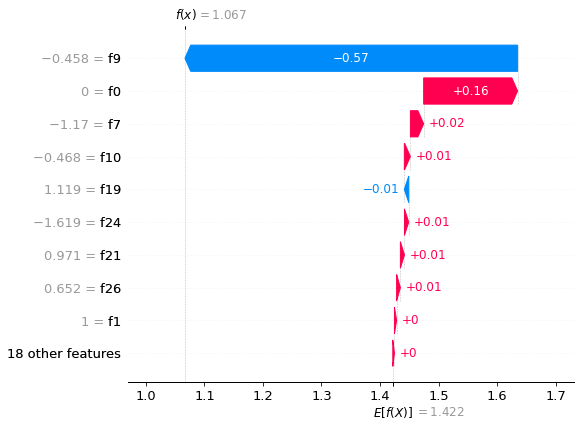

In [31]:
# X_train.columns = ['f'+f'{str(i)}' for i in range(len(X_train.columns))]

model_lgb = LGBMRegressor(**lgb_best).fit(X_train,y_train)

shap.initjs()
explainer = shap.Explainer(model_lgb)
shap_values = explainer(X_train)

shap.plots.waterfall(shap_values[0])

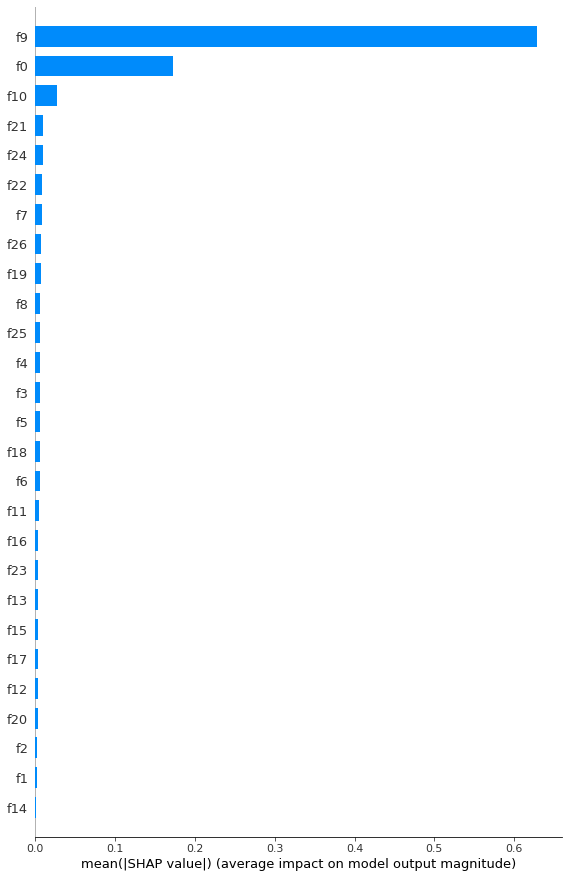

In [33]:
shap_values = shap.TreeExplainer(model_lgb).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar", max_display=int(len(X_train.columns)))

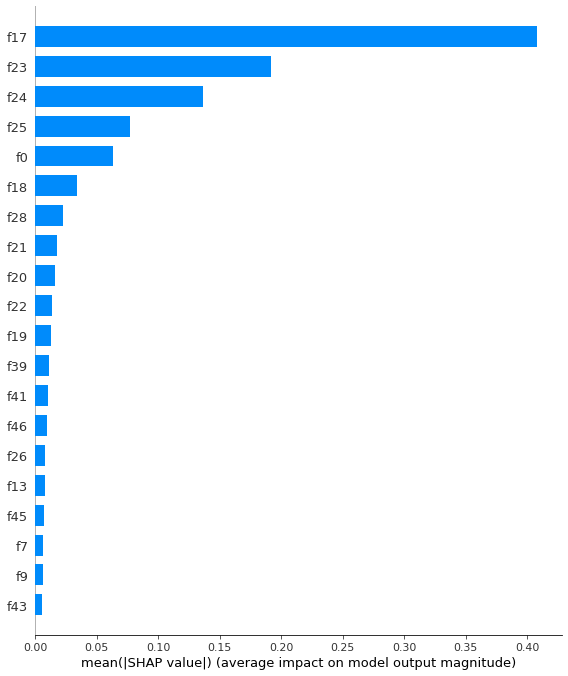

<Figure size 432x288 with 0 Axes>

In [124]:
shap_values = shap.TreeExplainer(model_lgb).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")
plt.savefig('force_plot.png')